# **0. Initilization & Load Dataset**

In [79]:
import os
import sys
import random
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import perf_counter
import gc

# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit

from src.utils.visualization import plot_model_metrics
from src.utils.scores import _regression_scores
from src.utils.performance_monitor import timed_mem_call

warnings.filterwarnings('ignore')

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
print(f'Seed: {SEED}')

# Enhanced Performance Monitoring Setup
performance_stats = {}
detailed_performance = {}

Seed: 42


In [59]:
def read_csv(file_path):
    df = pd.read_csv(file_path)
    display(df.head())

    X = df.drop('target', axis=1)
    y = df['target']
    display(y.value_counts())

    print('Shape df:  ', df.shape)
    print('Shape X:  ', X.shape)
    print('Shape y:  ', y.shape)

    return X, y

In [60]:
# Original Dataset
X_train, y_train = read_csv('../dataset/processed/splits/raw_train.csv')
X_val, y_val = read_csv('../dataset/processed/splits/raw_val.csv')
X_test, y_test = read_csv('../dataset/processed/splits/raw_test.csv')

# FE Dataset
X_fe_train, y_fe_train = read_csv('../dataset/processed/splits/fe_train.csv')
X_fe_val, y_fe_val = read_csv('../dataset/processed/splits/fe_val.csv')
X_fe_test, y_fe_test = read_csv('../dataset/processed/splits/fe_test.csv')

# Original + DT Dataset
X_dt_train, y_dt_train = read_csv('../dataset/processed/splits/dt_train.csv')
X_dt_val, y_dt_val = read_csv('../dataset/processed/splits/dt_val.csv')
X_dt_test, y_dt_test = read_csv('../dataset/processed/splits/dt_test.csv')

# FE + DT Dataset
X_fe_dt_train, y_fe_dt_train = read_csv('../dataset/processed/splits/fe_dt_train.csv')
X_fe_dt_val, y_fe_dt_val = read_csv('../dataset/processed/splits/fe_dt_val.csv')
X_fe_dt_test, y_fe_dt_test = read_csv('../dataset/processed/splits/fe_dt_test.csv')

,cat__name_An Giang,cat__name_Bình Dương,cat__name_Bình Phước,cat__name_Bạc Liêu,cat__name_Bến Tre,cat__name_Cà Mau,cat__name_Cần Thơ,cat__name_Hậu Giang,cat__name_Hồ Chí Minh,cat__name_Kiên Giang,cat__name_Sóc Trăng,cat__name_Tiền Giang,cat__name_Trà Vinh,cat__name_Tây Ninh,cat__name_Vĩnh Long,cat__name_Vũng Tàu,cat__name_Đồng Nai,cat__name_Đồng Tháp,num__humidity,num__precip,num__winddir,num__sealevelpressure,num__cloudcover,num__solarradiation,num__uvindex,num__tempmin_C,num__temp_C,num__feelslikemax_C,num__feelslike_C,num__year,num__month,num__day_of_year,num__day_of_week,num__quarter,target
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.8,0.000,348.8,1012.7,53.3,186.3,7.0,22.06,25.11,29.72,25.61,2015.0,1.0,1.0,3.0,1.0,26.06
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.6,0.008,354.4,1013.4,52.2,200.6,8.0,20.06,23.72,26.06,23.72,2015.0,1.0,2.0,4.0,1.0,29.06
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.8,0.008,350.1,1012.4,68.4,201.7,8.0,22.83,25.33,30.89,25.78,2015.0,1.0,3.0,5.0,1.0,30.06
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78.2,0.012,128.8,1010.6,66.4,144.0,6.0,22.06,26.22,33.39,27.44,2015.0,1.0,4.0,6.0,1.0,30.06
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0,0.119,150.2,1010.1,86.3,155.2,6.0,24.06,26.28,33.39,27.50,2015.0,1.0,5.0,0.0,1.0,31.06


target
33.00    6009
32.00    5859
31.00    4696
34.00    3736
30.00    2425
         ... 
23.67       1
23.44       1
36.78       1
23.83       1
26.78       1
Name: count, Length: 276, dtype: int64

Shape df:   (59184, 35)
Shape X:   (59184, 34)
Shape y:   (59184,)


,cat__name_An Giang,cat__name_Bình Dương,cat__name_Bình Phước,cat__name_Bạc Liêu,cat__name_Bến Tre,cat__name_Cà Mau,cat__name_Cần Thơ,cat__name_Hậu Giang,cat__name_Hồ Chí Minh,cat__name_Kiên Giang,cat__name_Sóc Trăng,cat__name_Tiền Giang,cat__name_Trà Vinh,cat__name_Tây Ninh,cat__name_Vĩnh Long,cat__name_Vũng Tàu,cat__name_Đồng Nai,cat__name_Đồng Tháp,num__humidity,num__precip,num__winddir,num__sealevelpressure,num__cloudcover,num__solarradiation,num__uvindex,num__tempmin_C,num__temp_C,num__feelslikemax_C,num__feelslike_C,num__year,num__month,num__day_of_year,num__day_of_week,num__quarter,target
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.2,0.000,105.2,1014.2,45.6,227.4,9.0,23.0,27.61,39.22,30.06,2024.0,2.0,32.0,3.0,1.0,32.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.8,0.004,101.3,1013.3,38.6,222.6,8.0,23.5,27.28,37.94,29.78,2024.0,2.0,33.0,4.0,1.0,32.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.4,0.000,111.1,1013.5,44.0,224.2,9.0,23.0,27.17,37.94,29.78,2024.0,2.0,34.0,5.0,1.0,33.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82.8,0.000,127.3,1013.9,40.1,222.2,8.0,23.0,27.28,39.28,30.00,2024.0,2.0,35.0,6.0,1.0,32.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.3,0.004,110.8,1013.7,34.2,207.2,8.0,23.0,27.33,39.22,30.56,2024.0,2.0,36.0,0.0,1.0,32.0


target
35.00    360
34.00    343
33.00    252
36.00    251
37.00    142
        ... 
27.67      1
26.22      1
29.11      1
29.61      1
26.89      1
Name: count, Length: 197, dtype: int64

Shape df:   (3276, 35)
Shape X:   (3276, 34)
Shape y:   (3276,)


,cat__name_An Giang,cat__name_Bình Dương,cat__name_Bình Phước,cat__name_Bạc Liêu,cat__name_Bến Tre,cat__name_Cà Mau,cat__name_Cần Thơ,cat__name_Hậu Giang,cat__name_Hồ Chí Minh,cat__name_Kiên Giang,cat__name_Sóc Trăng,cat__name_Tiền Giang,cat__name_Trà Vinh,cat__name_Tây Ninh,cat__name_Vĩnh Long,cat__name_Vũng Tàu,cat__name_Đồng Nai,cat__name_Đồng Tháp,num__humidity,num__precip,num__winddir,num__sealevelpressure,num__cloudcover,num__solarradiation,num__uvindex,num__tempmin_C,num__temp_C,num__feelslikemax_C,num__feelslike_C,num__year,num__month,num__day_of_year,num__day_of_week,num__quarter,target
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.3,0.024,261.4,1008.3,87.3,109.8,6.0,25.0,27.56,38.83,31.67,2024.0,8.0,244.0,5.0,3.0,31.00
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.5,1.220,267.0,1007.0,89.2,160.5,7.0,24.0,26.50,42.39,28.50,2024.0,9.0,245.0,6.0,3.0,29.00
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.5,1.299,227.1,1007.5,73.6,125.5,5.0,25.0,26.11,36.83,27.83,2024.0,9.0,246.0,0.0,3.0,29.00
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97.4,0.551,221.2,1008.8,65.7,174.6,7.0,24.0,25.94,38.17,27.50,2024.0,9.0,247.0,1.0,3.0,28.89
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.2,1.378,243.0,1007.9,70.2,149.9,7.0,24.0,25.61,36.06,26.56,2024.0,9.0,248.0,2.0,3.0,29.33


target
32.00    644
33.00    540
31.00    407
30.00    316
34.00    296
        ... 
26.67      1
24.78      1
24.83      1
25.56      1
28.28      1
Name: count, Length: 217, dtype: int64

Shape df:   (6570, 35)
Shape X:   (6570, 34)
Shape y:   (6570,)


,tempmax_C_lag1,tempmax_C_rollmean3,tempmax_C_lag2,tempmax_C_rollmean7,tempmax_C_lag3,tempmax_C_lag4,tempmin_C,temp_C,day_of_year,doy_sin,feelslikemax_C,doy_cos,feelslike_C,tempmax_C_rollstd7,humidity,cloudcover,month,solarradiation,winddir,target
0,30.06,30.393333,31.06,29.202857,30.06,30.06,24.06,26.78,8,0.137185,33.39,0.990545,28.06,1.676163,76.1,64.9,1,202.1,102.1,31.06
1,30.06,30.393333,30.06,29.488571,31.06,30.06,23.67,26.61,9,0.154204,32.50,0.988039,27.44,1.618347,72.9,55.2,1,224.0,93.7,31.06
2,31.06,30.393333,30.06,30.202857,30.06,31.06,23.06,26.67,10,0.171177,33.33,0.985240,27.83,0.690066,75.3,60.4,1,209.5,78.1,30.06
3,31.06,30.726667,31.06,30.488571,30.06,30.06,22.06,26.39,11,0.188099,32.67,0.982150,27.72,0.534522,80.0,67.8,1,222.3,104.4,30.06
4,30.06,30.726667,31.06,30.488571,31.06,30.06,22.06,25.89,12,0.204966,32.67,0.978769,26.72,0.534522,80.0,63.4,1,203.0,57.7,30.06


target
33.00    6009
32.00    5849
31.00    4696
34.00    3736
30.00    2422
         ... 
37.61       1
36.78       1
24.61       1
23.56       1
26.78       1
Name: count, Length: 276, dtype: int64

Shape df:   (59058, 20)
Shape X:   (59058, 19)
Shape y:   (59058,)


,tempmax_C_lag1,tempmax_C_rollmean3,tempmax_C_lag2,tempmax_C_rollmean7,tempmax_C_lag3,tempmax_C_lag4,tempmin_C,temp_C,day_of_year,doy_sin,feelslikemax_C,doy_cos,feelslike_C,tempmax_C_rollstd7,humidity,cloudcover,month,solarradiation,winddir,target
0,32.0,32.000000,32.0,32.285714,32.0,33.0,24.00,27.28,39,0.621687,37.72,0.783266,29.89,0.487950,85.9,42.2,2,211.9,109.1,33.00
1,31.0,31.666667,32.0,32.000000,32.0,32.0,23.00,27.33,40,0.635068,39.28,0.772456,30.11,0.577350,82.7,53.4,2,233.1,90.7,34.00
2,33.0,32.000000,31.0,32.142857,32.0,32.0,24.78,27.94,41,0.648262,36.78,0.761418,29.72,0.690066,75.9,39.0,2,255.3,86.3,32.00
3,34.0,32.666667,33.0,32.428571,31.0,32.0,24.00,27.61,42,0.661263,34.94,0.750154,29.00,0.975900,73.0,27.5,2,259.3,42.8,33.00
4,32.0,33.000000,34.0,32.285714,33.0,31.0,23.00,27.17,43,0.674069,34.00,0.738668,27.89,0.951190,70.2,38.7,2,276.5,68.5,33.22


target
35.00    351
34.00    343
36.00    251
33.00    238
37.00    142
        ... 
27.72      1
32.39      1
27.89      1
29.78      1
26.89      1
Name: count, Length: 196, dtype: int64

Shape df:   (3150, 20)
Shape X:   (3150, 19)
Shape y:   (3150,)


,tempmax_C_lag1,tempmax_C_rollmean3,tempmax_C_lag2,tempmax_C_rollmean7,tempmax_C_lag3,tempmax_C_lag4,tempmin_C,temp_C,day_of_year,doy_sin,feelslikemax_C,doy_cos,feelslike_C,tempmax_C_rollstd7,humidity,cloudcover,month,solarradiation,winddir,target
0,32.00,30.073333,29.33,29.888571,28.89,29.00,26.0,27.22,251,-0.923158,39.67,-0.384421,30.83,1.196807,96.4,75.6,9,199.8,239.0,30.67
1,30.06,30.463333,32.00,29.897143,29.33,28.89,25.0,26.67,252,-0.929634,40.67,-0.368484,28.83,1.197953,96.2,68.4,9,199.9,239.2,32.50
2,30.67,30.910000,30.06,29.850000,32.00,29.33,25.0,28.22,253,-0.935835,42.56,-0.352439,33.44,1.152967,91.2,60.5,9,225.8,262.6,32.00
3,32.50,31.076667,30.67,30.350000,30.06,32.00,27.0,28.83,254,-0.941759,44.17,-0.336289,36.50,1.444876,91.8,52.2,9,225.1,256.0,31.00
4,32.00,31.723333,32.50,30.778571,30.67,30.06,26.0,27.44,255,-0.947404,44.33,-0.320039,31.61,1.422456,96.4,73.7,9,194.7,241.1,31.00


target
32.00    635
33.00    537
31.00    399
30.00    302
34.00    296
        ... 
24.78      1
24.83      1
25.56      1
26.11      1
28.28      1
Name: count, Length: 216, dtype: int64

Shape df:   (6444, 20)
Shape X:   (6444, 19)
Shape y:   (6444,)


,cat__name_Bạc Liêu,cat__name_Đồng Nai,num__humidity,num__precip,num__winddir,num__sealevelpressure,num__cloudcover,num__solarradiation,num__uvindex,num__tempmin_C,num__temp_C,num__feelslikemax_C,num__feelslike_C,num__year,num__month,num__day_of_year,num__day_of_week,target
0,0.0,0.0,78.8,0.000,348.8,1012.7,53.3,186.3,7.0,22.06,25.11,29.72,25.61,2015.0,1.0,1.0,3.0,26.06
1,0.0,0.0,68.6,0.008,354.4,1013.4,52.2,200.6,8.0,20.06,23.72,26.06,23.72,2015.0,1.0,2.0,4.0,29.06
2,0.0,0.0,73.8,0.008,350.1,1012.4,68.4,201.7,8.0,22.83,25.33,30.89,25.78,2015.0,1.0,3.0,5.0,30.06
3,0.0,0.0,78.2,0.012,128.8,1010.6,66.4,144.0,6.0,22.06,26.22,33.39,27.44,2015.0,1.0,4.0,6.0,30.06
4,0.0,0.0,85.0,0.119,150.2,1010.1,86.3,155.2,6.0,24.06,26.28,33.39,27.50,2015.0,1.0,5.0,0.0,31.06


target
33.00    6009
32.00    5859
31.00    4696
34.00    3736
30.00    2425
         ... 
23.67       1
23.44       1
36.78       1
23.83       1
26.78       1
Name: count, Length: 276, dtype: int64

Shape df:   (59184, 18)
Shape X:   (59184, 17)
Shape y:   (59184,)


,cat__name_Bạc Liêu,cat__name_Đồng Nai,num__humidity,num__precip,num__winddir,num__sealevelpressure,num__cloudcover,num__solarradiation,num__uvindex,num__tempmin_C,num__temp_C,num__feelslikemax_C,num__feelslike_C,num__year,num__month,num__day_of_year,num__day_of_week,target
0,0.0,0.0,81.2,0.000,105.2,1014.2,45.6,227.4,9.0,23.0,27.61,39.22,30.06,2024.0,2.0,32.0,3.0,32.0
1,0.0,0.0,83.8,0.004,101.3,1013.3,38.6,222.6,8.0,23.5,27.28,37.94,29.78,2024.0,2.0,33.0,4.0,32.0
2,0.0,0.0,83.4,0.000,111.1,1013.5,44.0,224.2,9.0,23.0,27.17,37.94,29.78,2024.0,2.0,34.0,5.0,33.0
3,0.0,0.0,82.8,0.000,127.3,1013.9,40.1,222.2,8.0,23.0,27.28,39.28,30.00,2024.0,2.0,35.0,6.0,32.0
4,0.0,0.0,86.3,0.004,110.8,1013.7,34.2,207.2,8.0,23.0,27.33,39.22,30.56,2024.0,2.0,36.0,0.0,32.0


target
35.00    360
34.00    343
33.00    252
36.00    251
37.00    142
        ... 
27.67      1
26.22      1
29.11      1
29.61      1
26.89      1
Name: count, Length: 197, dtype: int64

Shape df:   (3276, 18)
Shape X:   (3276, 17)
Shape y:   (3276,)


,cat__name_Bạc Liêu,cat__name_Đồng Nai,num__humidity,num__precip,num__winddir,num__sealevelpressure,num__cloudcover,num__solarradiation,num__uvindex,num__tempmin_C,num__temp_C,num__feelslikemax_C,num__feelslike_C,num__year,num__month,num__day_of_year,num__day_of_week,target
0,0.0,0.0,90.3,0.024,261.4,1008.3,87.3,109.8,6.0,25.0,27.56,38.83,31.67,2024.0,8.0,244.0,5.0,31.00
1,0.0,0.0,96.5,1.220,267.0,1007.0,89.2,160.5,7.0,24.0,26.50,42.39,28.50,2024.0,9.0,245.0,6.0,29.00
2,0.0,0.0,97.5,1.299,227.1,1007.5,73.6,125.5,5.0,25.0,26.11,36.83,27.83,2024.0,9.0,246.0,0.0,29.00
3,0.0,0.0,97.4,0.551,221.2,1008.8,65.7,174.6,7.0,24.0,25.94,38.17,27.50,2024.0,9.0,247.0,1.0,28.89
4,0.0,0.0,98.2,1.378,243.0,1007.9,70.2,149.9,7.0,24.0,25.61,36.06,26.56,2024.0,9.0,248.0,2.0,29.33


target
32.00    644
33.00    540
31.00    407
30.00    316
34.00    296
        ... 
26.67      1
24.78      1
24.83      1
25.56      1
28.28      1
Name: count, Length: 217, dtype: int64

Shape df:   (6570, 18)
Shape X:   (6570, 17)
Shape y:   (6570,)


,humidity,precip,winddir,sealevelpressure,cloudcover,solarradiation,tempmin_C,temp_C,feelslikemax_C,feelslike_C,year,day_of_year,day_of_week,tempmax_C_lag1,tempmax_C_lag2,tempmax_C_lag3,tempmax_C_lag4,tempmax_C_rollmean7,tempmax_C_rollmean3,tempmax_C_rollstd7,month_sin,doy_sin,doy_cos,target
0,76.1,0.004,102.1,1011.8,64.9,202.1,24.06,26.78,33.39,28.06,2015.0,8.0,3.0,30.06,31.06,30.06,30.06,29.202857,30.393333,1.676163,0.5,0.137185,0.990545,31.06
1,72.9,0.205,93.7,1012.4,55.2,224.0,23.67,26.61,32.50,27.44,2015.0,9.0,4.0,30.06,30.06,31.06,30.06,29.488571,30.393333,1.618347,0.5,0.154204,0.988039,31.06
2,75.3,0.000,78.1,1011.7,60.4,209.5,23.06,26.67,33.33,27.83,2015.0,10.0,5.0,31.06,30.06,30.06,31.06,30.202857,30.393333,0.690066,0.5,0.171177,0.985240,30.06
3,80.0,0.000,104.4,1011.5,67.8,222.3,22.06,26.39,32.67,27.72,2015.0,11.0,6.0,31.06,31.06,30.06,30.06,30.488571,30.726667,0.534522,0.5,0.188099,0.982150,30.06
4,80.0,0.000,57.7,1011.7,63.4,203.0,22.06,25.89,32.67,26.72,2015.0,12.0,0.0,30.06,31.06,31.06,30.06,30.488571,30.726667,0.534522,0.5,0.204966,0.978769,30.06


target
33.00    6009
32.00    5849
31.00    4696
34.00    3736
30.00    2422
         ... 
37.61       1
36.78       1
24.61       1
23.56       1
26.78       1
Name: count, Length: 276, dtype: int64

Shape df:   (59058, 24)
Shape X:   (59058, 23)
Shape y:   (59058,)


,humidity,precip,winddir,sealevelpressure,cloudcover,solarradiation,tempmin_C,temp_C,feelslikemax_C,feelslike_C,year,day_of_year,day_of_week,tempmax_C_lag1,tempmax_C_lag2,tempmax_C_lag3,tempmax_C_lag4,tempmax_C_rollmean7,tempmax_C_rollmean3,tempmax_C_rollstd7,month_sin,doy_sin,doy_cos,target
0,85.9,0.000,109.1,1011.9,42.2,211.9,24.00,27.28,37.72,29.89,2024.0,39.0,3.0,32.0,32.0,32.0,33.0,32.285714,32.000000,0.487950,0.866025,0.621687,0.783266,33.00
1,82.7,0.004,90.7,1013.4,53.4,233.1,23.00,27.33,39.28,30.11,2024.0,40.0,4.0,31.0,32.0,32.0,32.0,32.000000,31.666667,0.577350,0.866025,0.635068,0.772456,34.00
2,75.9,0.000,86.3,1014.7,39.0,255.3,24.78,27.94,36.78,29.72,2024.0,41.0,5.0,33.0,31.0,32.0,32.0,32.142857,32.000000,0.690066,0.866025,0.648262,0.761418,32.00
3,73.0,0.000,42.8,1016.0,27.5,259.3,24.00,27.61,34.94,29.00,2024.0,42.0,6.0,34.0,33.0,31.0,32.0,32.428571,32.666667,0.975900,0.866025,0.661263,0.750154,33.00
4,70.2,0.000,68.5,1015.5,38.7,276.5,23.00,27.17,34.00,27.89,2024.0,43.0,0.0,32.0,34.0,33.0,31.0,32.285714,33.000000,0.951190,0.866025,0.674069,0.738668,33.22


target
35.00    351
34.00    343
36.00    251
33.00    238
37.00    142
        ... 
27.72      1
32.39      1
27.89      1
29.78      1
26.89      1
Name: count, Length: 196, dtype: int64

Shape df:   (3150, 24)
Shape X:   (3150, 23)
Shape y:   (3150,)


,humidity,precip,winddir,sealevelpressure,cloudcover,solarradiation,tempmin_C,temp_C,feelslikemax_C,feelslike_C,year,day_of_year,day_of_week,tempmax_C_lag1,tempmax_C_lag2,tempmax_C_lag3,tempmax_C_lag4,tempmax_C_rollmean7,tempmax_C_rollmean3,tempmax_C_rollstd7,month_sin,doy_sin,doy_cos,target
0,96.4,0.630,239.0,1007.8,75.6,199.8,26.0,27.22,39.67,30.83,2024.0,251.0,5.0,32.00,29.33,28.89,29.00,29.888571,30.073333,1.196807,-1.0,-0.923158,-0.384421,30.67
1,96.2,1.339,239.2,1009.4,68.4,199.9,25.0,26.67,40.67,28.83,2024.0,252.0,6.0,30.06,32.00,29.33,28.89,29.897143,30.463333,1.197953,-1.0,-0.929634,-0.368484,32.50
2,91.2,0.118,262.6,1007.6,60.5,225.8,25.0,28.22,42.56,33.44,2024.0,253.0,0.0,30.67,30.06,32.00,29.33,29.850000,30.910000,1.152967,-1.0,-0.935835,-0.352439,32.00
3,91.8,0.190,256.0,1007.0,52.2,225.1,27.0,28.83,44.17,36.50,2024.0,254.0,1.0,32.50,30.67,30.06,32.00,30.350000,31.076667,1.444876,-1.0,-0.941759,-0.336289,31.00
4,96.4,0.079,241.1,1008.2,73.7,194.7,26.0,27.44,44.33,31.61,2024.0,255.0,2.0,32.00,32.50,30.67,30.06,30.778571,31.723333,1.422456,-1.0,-0.947404,-0.320039,31.00


target
32.00    635
33.00    537
31.00    399
30.00    302
34.00    296
        ... 
24.78      1
24.83      1
25.56      1
26.11      1
28.28      1
Name: count, Length: 216, dtype: int64

Shape df:   (6444, 24)
Shape X:   (6444, 23)
Shape y:   (6444,)


# **1. Random Forest**

## 1.1. Find Optimal RF Function

In [61]:
# tìm n_estimators tối ưu cho time series
def find_optimal_rf_timeseries(
    X_train, y_train,
    n_estimators_range=(100, 200, 300, 500),
    cv_splits=6, gap=7, metric="mae",
    random_state=SEED, n_jobs=-1,
    # tham số RF cốt lõi
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=2,      # tăng nhẹ để ổn định hơn
    max_features=0.5,        
    bootstrap=True,
    plot=True
):
    # chọn hàm đánh giá
    metric = metric.lower()
    if metric == "mae":
        scorer = lambda y_true, y_pred: mean_absolute_error(y_true, y_pred)
        ylabel = "CV MAE (lower is better)"
    elif metric == "rmse":
        scorer = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
        ylabel = "CV RMSE (lower is better)"
    else:
        raise ValueError("metric must be 'mae' or 'rmse'")

    X, y = X_train, y_train

    # tiền tính các split để dùng lại cho mọi n_estimators
    tscv = TimeSeriesSplit(n_splits=cv_splits, gap=gap)
    splits = list(tscv.split(X))

    ns = list(n_estimators_range)
    meds, stds = [], []

    for n in ns:
        fold_scores = []
        for tr_idx, va_idx in splits:
            X_tr = X.iloc[tr_idx] if hasattr(X, "iloc") else X[tr_idx]
            X_va = X.iloc[va_idx] if hasattr(X, "iloc") else X[va_idx]
            y_tr = y.iloc[tr_idx] if hasattr(y, "iloc") else y[tr_idx]
            y_va = y.iloc[va_idx] if hasattr(y, "iloc") else y[va_idx]

            rf = RandomForestRegressor(
                n_estimators=n,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                max_features=max_features,
                bootstrap=bootstrap,
                n_jobs=n_jobs,
                random_state=random_state,
            )
            rf.fit(X_tr, y_tr)
            pred = rf.predict(X_va)
            fold_scores.append(scorer(y_va, pred))

        meds.append(np.median(fold_scores))  # dùng median để chống nhiễu
        stds.append(np.std(fold_scores))

    # chọn n có điểm số trung vị nhỏ nhất
    best_idx = int(np.argmin(meds))
    best_n = ns[best_idx]

    if plot:
        plt.figure(figsize=(9, 5))
        plt.errorbar(ns, meds, yerr=stds, fmt='o-', capsize=4)
        plt.title(f"Tối ưu n_estimators cho RF (TimeSeriesSplit={cv_splits}, gap={gap})")
        plt.xlabel("n_estimators")
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.show()

    print(f"n_estimators tối ưu (CV): {best_n} | {ylabel.split()[0]} = {meds[best_idx]:.4f} ± {stds[best_idx]:.4f}")

    # huấn luyện lại mô hình tốt nhất trên toàn bộ train
    best_model = RandomForestRegressor(
        n_estimators=best_n,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        n_jobs=n_jobs,
        random_state=random_state,
    )
    best_model.fit(X, y)

    cv_table = {
        "n_estimators": ns,
        "cv_median": meds,
        "cv_std": stds,
        "metric": metric,
    }
    return best_model, best_n, cv_table

## 1.2. Evaluate Function 

In [62]:
#đánh giá trên tập validation
def evaluate_val_rf_reg(
    X_train, y_train, X_val, y_val,
    n_estimators_range=(100, 200, 300, 500),
    cv_splits=6, gap=7, metric='mae',
    max_depth=None, min_samples_split=2, min_samples_leaf=2,
    max_features=0.5, bootstrap=True, random_state=SEED, n_jobs=-1,
    plot=True
):
    """
    Tìm n_estimators tối ưu bằng TimeSeriesSplit trên (X_train, y_train),
    sau đó đánh giá trên tập validation (X_val, y_val) với MAE/RMSE/R².
    """
    print('Tìm n_estimators tối ưu cho Random Forest Regressor (TimeSeriesSplit)')

    best_model, best_n, cv_table = find_optimal_rf_timeseries(
        X_train, y_train,
        n_estimators_range=n_estimators_range,
        cv_splits=cv_splits, gap=gap, metric=metric,
        max_depth=max_depth, min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf, max_features=max_features,
        bootstrap=bootstrap, random_state=random_state, n_jobs=n_jobs,
        plot=plot
    )

    val_pred = best_model.predict(X_val)
    val_mae, val_rmse, val_r2 = _regression_scores(y_val, val_pred)

    print(f'\nHiệu năng trên Validation:')
    print(f'  MAE : {val_mae:.4f}')
    print(f'  RMSE: {val_rmse:.4f}')
    print(f'  R²  : {val_r2:.4f}')

    return best_model, {"val_mae": val_mae, "val_rmse": val_rmse, "val_r2": val_r2}, {"n_estimators": best_n, "cv": cv_table}

# đánh giá trên tập test
def evaluate_test_rf_reg(rf_model, X_test, y_test):
    """
    Đánh giá mô hình RF đã chọn trên tập test hold-out.
    """
    test_pred = rf_model.predict(X_test)
    test_mae, test_rmse, test_r2 = _regression_scores(y_test, test_pred)

    print(f'\nHiệu năng trên Test:')
    print(f'  MAE : {test_mae:.4f}')
    print(f'  RMSE: {test_rmse:.4f}')
    print(f'  R²  : {test_r2:.4f}')

    return {"test_mae": test_mae, "test_rmse": test_rmse, "test_r2": test_r2}

## 1.3. 4-Way Evaluation of Random Forest:
- Original Dataset
- Feature-Engineered (FE) Dataset
- Original + Decision Tree (DT) Selected Features
- FE + DT

Tìm n_estimators tối ưu cho Random Forest Regressor (TimeSeriesSplit)


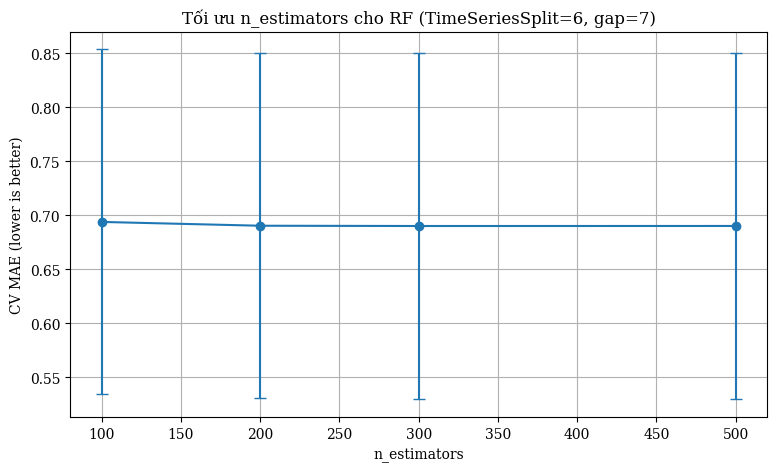

n_estimators tối ưu (CV): 300 | CV = 0.6900 ± 0.1600

Hiệu năng trên Validation:
  MAE : 0.9891
  RMSE: 1.2321
  R²  : 0.6803
[RF Original (CV+Val)] time=59.55s | Py-peak=52.3 MB | RSS(before/after/delta)=753.0/2534.0/1781.1 MB

Hiệu năng trên Test:
  MAE : 1.0078
  RMSE: 1.3134
  R²  : 0.5885
[RF Original (Test)] time=0.06s | Py-peak=2.2 MB | RSS(before/after/delta)=2534.4/2535.1/0.8 MB
Tìm n_estimators tối ưu cho Random Forest Regressor (TimeSeriesSplit)


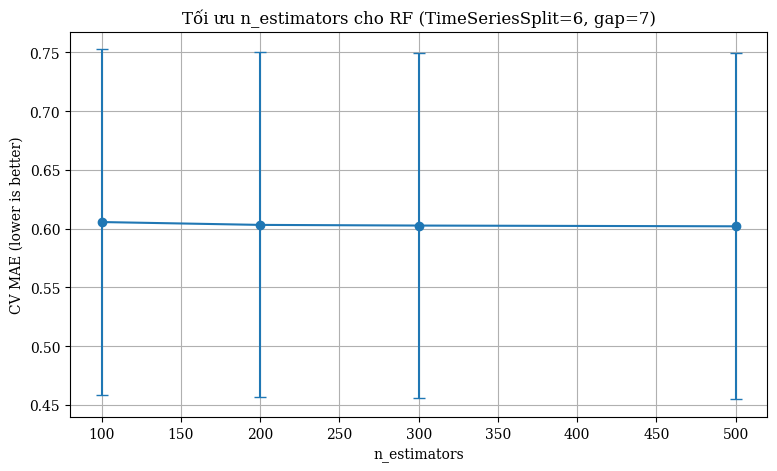

n_estimators tối ưu (CV): 500 | CV = 0.6020 ± 0.1473

Hiệu năng trên Validation:
  MAE : 0.9514
  RMSE: 1.2042
  R²  : 0.6975
[RF FE (CV+Val)] time=85.64s | Py-peak=42.2 MB | RSS(before/after/delta)=2535.1/2616.9/81.8 MB

Hiệu năng trên Test:
  MAE : 0.9960
  RMSE: 1.2936
  R²  : 0.6006
[RF FE (Test)] time=0.10s | Py-peak=1.7 MB | RSS(before/after/delta)=2733.9/2735.5/1.6 MB
Tìm n_estimators tối ưu cho Random Forest Regressor (TimeSeriesSplit)


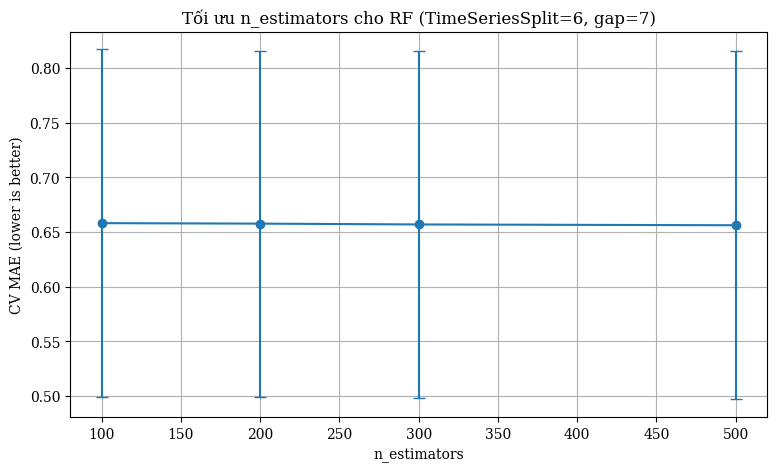

n_estimators tối ưu (CV): 500 | CV = 0.6561 ± 0.1591

Hiệu năng trên Validation:
  MAE : 0.9914
  RMSE: 1.2348
  R²  : 0.6790
[RF DT (CV+Val)] time=56.96s | Py-peak=40.4 MB | RSS(before/after/delta)=2735.5/3947.8/1212.2 MB

Hiệu năng trên Test:
  MAE : 1.0154
  RMSE: 1.3205
  R²  : 0.5840
[RF DT (Test)] time=0.08s | Py-peak=1.8 MB | RSS(before/after/delta)=3949.0/3950.7/1.6 MB
Tìm n_estimators tối ưu cho Random Forest Regressor (TimeSeriesSplit)


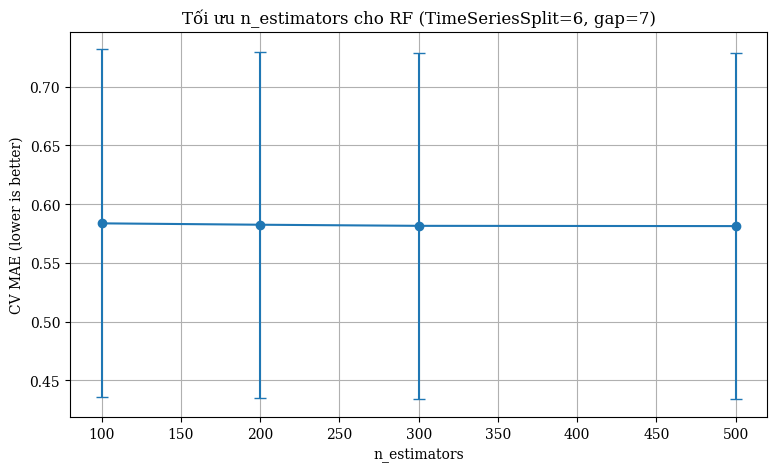

n_estimators tối ưu (CV): 500 | CV = 0.5813 ± 0.1474

Hiệu năng trên Validation:
  MAE : 0.9394
  RMSE: 1.1904
  R²  : 0.7044
[RF FE+DT (CV+Val)] time=84.62s | Py-peak=44.2 MB | RSS(before/after/delta)=3950.7/4626.7/676.0 MB

Hiệu năng trên Test:
  MAE : 0.9903
  RMSE: 1.2818
  R²  : 0.6078
[RF FE+DT (Test)] time=0.09s | Py-peak=1.8 MB | RSS(before/after/delta)=4627.4/4629.1/1.6 MB


,run,val_mae,val_rmse,val_r2,seconds,py_peak_mb,rss_before_mb,rss_after_mb,rss_delta_mb,test_mae,test_rmse,test_r2
0,RF Original (CV+Val),0.989054,1.232145,0.680329,59.546790,52.289907,752.984375,2534.046875,1781.062500,NaN,NaN,NaN
1,RF Original (Test),NaN,NaN,NaN,0.057705,2.179948,2534.375000,2535.140625,0.765625,1.007827,1.313391,0.588506
2,RF FE (CV+Val),0.951405,1.204203,0.697490,85.644433,42.238856,2535.140625,2616.921875,81.781250,NaN,NaN,NaN
3,RF FE (Test),NaN,NaN,NaN,0.102770,1.706436,2733.921875,2735.531250,1.609375,0.995995,1.293582,0.600595
4,RF DT (CV+Val),0.991398,1.234757,0.678972,56.964638,40.397796,2735.531250,3947.750000,1212.218750,NaN,NaN,NaN
5,RF DT (Test),NaN,NaN,NaN,0.083584,1.773376,3949.015625,3950.656250,1.640625,1.015362,1.320513,0.584031
6,RF FE+DT (CV+Val),0.939394,1.190363,0.704403,84.618926,44.225965,3950.656250,4626.687500,676.031250,NaN,NaN,NaN
7,RF FE+DT (Test),NaN,NaN,NaN,0.094918,1.844269,4627.421875,4629.062500,1.640625,0.990320,1.281787,0.607845


In [63]:
runs = []

# 1) RF on Original Dataset (CV + Val)
(res1, stats1) = timed_mem_call(
    evaluate_val_rf_reg,
    X_train, y_train, X_val, y_val,
    label="RF Original (CV+Val)"
)
rf_model, rf_val_metrics, ab_info = res1
runs.append({"run": "RF Original (CV+Val)", **rf_val_metrics, **stats1})

# Test
(res1t, stats1t) = timed_mem_call(
    evaluate_test_rf_reg,
    rf_model, X_test, y_test,
    label="RF Original (Test)"
)
rf_test_metrics = res1t
runs.append({"run": "RF Original (Test)", **rf_test_metrics, **stats1t})

# 2) RF on FE Dataset (CV + Val)
(res2, stats2) = timed_mem_call(
    evaluate_val_rf_reg,
    X_fe_train, y_fe_train, X_fe_val, y_fe_val,
    label="RF FE (CV+Val)"
)
rf_fe_model, rf_val_fe_metrics, ab_fe_info = res2
runs.append({"run": "RF FE (CV+Val)", **rf_val_fe_metrics, **stats2})

# Test
(res2t, stats2t) = timed_mem_call(
    evaluate_test_rf_reg,
    rf_fe_model, X_fe_test, y_fe_test,
    label="RF FE (Test)"
)
rf_test_fe_metrics = res2t
runs.append({"run": "RF FE (Test)", **rf_test_fe_metrics, **stats2t})

# 3) RF on Original + DT (CV + Val)
(res3, stats3) = timed_mem_call(
    evaluate_val_rf_reg,
    X_dt_train, y_dt_train, X_dt_val, y_dt_val,
    label="RF DT (CV+Val)"
)
rf_dt_model, rf_val_dt_metrics, ab_dt_info = res3
runs.append({"run": "RF DT (CV+Val)", **rf_val_dt_metrics, **stats3})

# Test
(res3t, stats3t) = timed_mem_call(
    evaluate_test_rf_reg,
    rf_dt_model, X_dt_test, y_dt_test,
    label="RF DT (Test)"
)
rf_test_dt_metrics = res3t
runs.append({"run": "RF DT (Test)", **rf_test_dt_metrics, **stats3t})

# 4) RF on FE + DT (CV + Val)
(res4, stats4) = timed_mem_call(
    evaluate_val_rf_reg,
    X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val,
    label="RF FE+DT (CV+Val)"
)
rf_fe_dt_model, rf_val_fe_dt_metrics, ab_fe_dt_info = res4
runs.append({"run": "RF FE+DT (CV+Val)", **rf_val_fe_dt_metrics, **stats4})

# Test
(res4t, stats4t) = timed_mem_call(
    evaluate_test_rf_reg,
    rf_fe_dt_model, X_fe_dt_test, y_fe_dt_test,
    label="RF FE+DT (Test)"
)
rf_test_fe_dt_metrics = res4t
runs.append({"run": "RF FE+DT (Test)", **rf_test_fe_dt_metrics, **stats4t})


df_runs = pd.DataFrame(runs)
display(df_runs)

## 1.4. 📈 Random Forest Performance Visualization
- Bar plots for Validation vs Test MAE
- Bar plots for Validation vs Test RMSE
- Bar plots for Validation vs Test R²

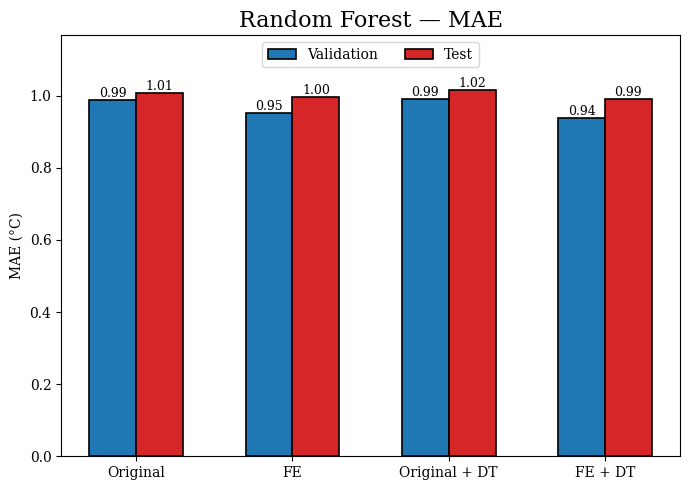

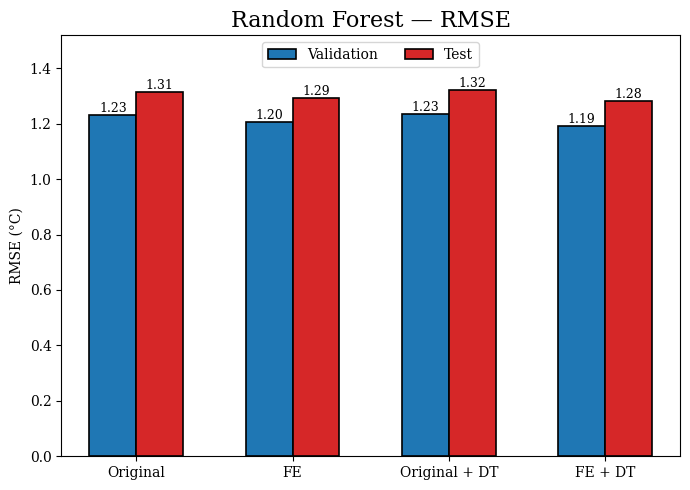

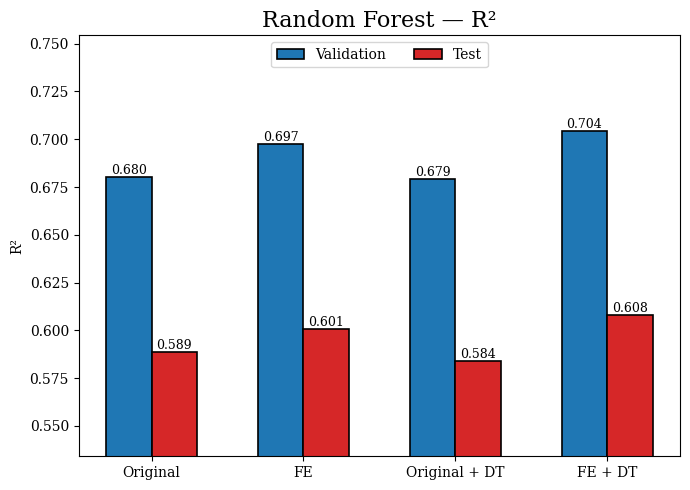

In [34]:
# MAE
plot_model_metrics(
    model_name='Random Forest',
    val_metric_dicts=[rf_val_metrics, rf_val_fe_metrics, rf_val_dt_metrics, rf_val_fe_dt_metrics],
    test_metric_dicts=[rf_test_metrics, rf_test_fe_metrics, rf_test_dt_metrics, rf_test_fe_dt_metrics],
    metric='mae'
)

# RMSE
plot_model_metrics(
    model_name='Random Forest',
    val_metric_dicts=[rf_val_metrics, rf_val_fe_metrics, rf_val_dt_metrics, rf_val_fe_dt_metrics],
    test_metric_dicts=[rf_test_metrics, rf_test_fe_metrics, rf_test_dt_metrics, rf_test_fe_dt_metrics],
    metric='rmse'
)

# R²
plot_model_metrics(
    model_name='Random Forest',
    val_metric_dicts=[rf_val_metrics, rf_val_fe_metrics, rf_val_dt_metrics, rf_val_fe_dt_metrics],
    test_metric_dicts=[rf_test_metrics, rf_test_fe_metrics, rf_test_dt_metrics, rf_test_fe_dt_metrics],
    metric='r2'
)

# **2. AdaBoost**

## 2.1. Find Optimal AdaBoost Function

In [35]:
def find_optimal_ada_reg_with_custom_score(
    X_train, y_train,
    n_estimators_range=range(10, 101, 10),
    cv_splits=5,
    gap=0,
    test_size=None,
    learning_rate=0.1,
    base_max_depth=3,
    loss="linear",
    main_metric="MAE"
):
    """
    Dùng TimeSeriesSplit (có gap) và hàm _regression_scores để tìm n_estimators tối ưu.
    Trả về: best_model, best_n, best_metric_value, history
    """
    if test_size is not None:
        cv = TimeSeriesSplit(n_splits=cv_splits, gap=gap, test_size=test_size)
    else:
        cv = TimeSeriesSplit(n_splits=cv_splits, gap=gap)

    n_list = list(n_estimators_range)
    # Lưu trung bình 3 metrics cho mỗi n_estimators
    all_mae, all_rmse, all_r2 = [], [], []

    for n in n_list:
        fold_mae, fold_rmse, fold_r2 = [], [], []

        # CV thủ công
        for tr_idx, va_idx in cv.split(X_train):
            X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
            y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

            model = AdaBoostRegressor(
                estimator=DecisionTreeRegressor(max_depth=base_max_depth, random_state=SEED),
                n_estimators=n,
                learning_rate=learning_rate,
                loss=loss,
                random_state=SEED
            )
            model.fit(X_tr, y_tr)
            preds = model.predict(X_va)

            mae, rmse, r2 = _regression_scores(y_va, preds)
            fold_mae.append(mae)
            fold_rmse.append(rmse)
            fold_r2.append(r2)

        all_mae.append(np.mean(fold_mae))
        all_rmse.append(np.mean(fold_rmse))
        all_r2.append(np.mean(fold_r2))

    # Chọn metric chính
    if main_metric.upper() == "MAE":
        best_idx = int(np.argmin(all_mae))
        best_val = all_mae[best_idx]
    elif main_metric.upper() == "RMSE":
        best_idx = int(np.argmin(all_rmse))
        best_val = all_rmse[best_idx]
    elif main_metric.upper() == "R2":
        best_idx = int(np.argmax(all_r2))
        best_val = all_r2[best_idx]
    else:
        raise ValueError("main_metric phải là 'MAE', 'RMSE' hoặc 'R2'")

    best_n = n_list[best_idx]
    print(f"Best n_estimators theo {main_metric}: {best_n} — {main_metric} = {best_val:.4f}")

    # Vẽ đường cong theo metric chính
    plt.figure(figsize=(10,6))
    if main_metric.upper() == "MAE":
        plt.plot(n_list, all_mae, 'o-', label='MAE (↓)')
    elif main_metric.upper() == "RMSE":
        plt.plot(n_list, all_rmse, 'o-', label='RMSE (↓)')
    else:
        plt.plot(n_list, all_r2, 'o-', label='R² (↑)')

    plt.title(f'AdaBoostRegressor CV ({cv_splits}-fold) — {main_metric}')
    plt.xlabel('n_estimators')
    plt.ylabel(main_metric)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Huấn luyện mô hình cuối cùng với best_n
    best_model = AdaBoostRegressor(
        estimator=DecisionTreeRegressor(max_depth=base_max_depth, random_state=SEED),
        n_estimators=best_n,
        learning_rate=learning_rate,
        loss=loss,
        random_state=SEED
    )
    best_model.fit(X_train, y_train)

    history = {
        'n_list': n_list,
        'mae': all_mae,
        'rmse': all_rmse,
        'r2': all_r2
    }

    return best_model, best_n, best_val, history

## 2.2. Evaluate Function

In [36]:
def evaluate_val_ada_reg(
    X_train, y_train, X_val, y_val,
    n_estimators_range=range(10, 101, 10),
    cv_splits=5,
    gap=0,
    test_size=None,
    learning_rate=0.1,
    base_max_depth=3,
    loss='linear',        # {'linear','square','exponential'}
    main_metric='MAE'     # {'MAE','RMSE','R2'} để chọn best_n trong CV
):
    """
    1. Tìm n_estimators tối ưu bằng CV theo TimeSeries (có thể có gap) với metric chính.
    2. Fit lại model tốt nhất trên toàn bộ X_train, y_train.
    3. Đánh giá trên X_val, y_val bằng _regression_scores (MAE, RMSE, R²).
    Trả về: model, val_metrics_dict, info_dict
    """

    best_model, best_n, cv_best_val, history = find_optimal_ada_reg_with_custom_score(
        X_train, y_train,
        n_estimators_range=n_estimators_range,
        cv_splits=cv_splits,
        gap=gap,
        test_size=test_size,
        learning_rate=learning_rate,
        base_max_depth=base_max_depth,
        loss=loss,
        main_metric=main_metric
    )

    # Đánh giá trên validation
    val_pred = best_model.predict(X_val)
    val_mae, val_rmse, val_r2 = _regression_scores(y_val, val_pred)

    print("\nHiệu năng AdaBoostRegressor trên tập validation:")
    print(f"- MAE : {val_mae:.4f}")
    print(f"- RMSE: {val_rmse:.4f}")
    print(f"- R²  : {val_r2:.4f}")

    val_metrics = {"mae": val_mae, "rmse": val_rmse, "r2": val_r2}
    info = {
        "n_estimators": best_n,
        "cv_metric": main_metric,
        "cv_best": cv_best_val,   # giá trị trung bình tốt nhất trong CV theo metric chính
        "history": history        
    }
    return best_model, val_metrics, info


def evaluate_test_ada_reg(model, X_test, y_test):
    """
    Đánh giá model AdaBoostRegressor trên tập test bằng _regression_scores().
    Trả về: test_metrics_dict
    """
    test_pred = model.predict(X_test)
    test_mae, test_rmse, test_r2 = _regression_scores(y_test, test_pred)

    print("\nHiệu năng AdaBoostRegressor trên tập test:")
    print(f"- MAE : {test_mae:.4f}")
    print(f"- RMSE: {test_rmse:.4f}")
    print(f"- R²  : {test_r2:.4f}")

    return {"mae": test_mae, "rmse": test_rmse, "r2": test_r2}

## 2.3. 4-Way Evaluation of AdaBoost
- Original Dataset
- Feature-Engineered (FE) Dataset
- Original + Decision Tree (DT) Selected Features
- FE + DT

Best n_estimators theo MAE: 30 — MAE = 1.0759


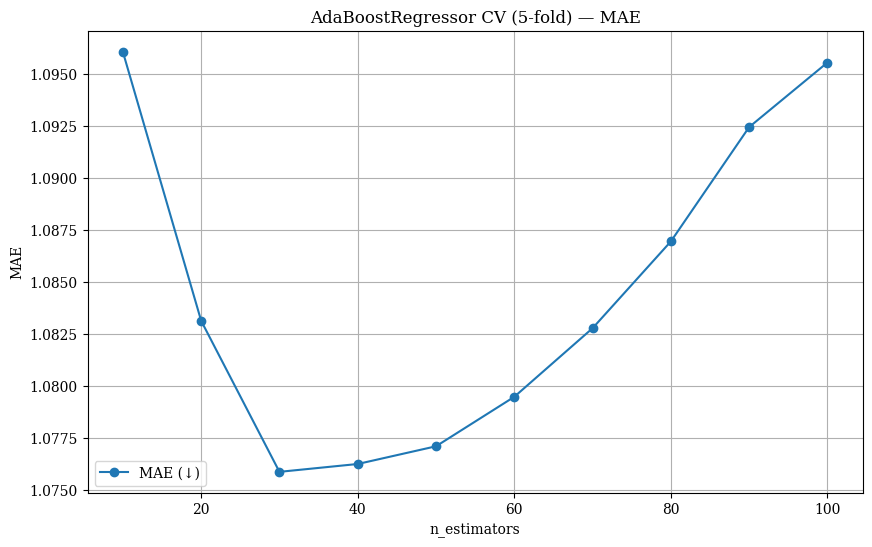


Hiệu năng AdaBoostRegressor trên tập validation:
- MAE : 1.2379
- RMSE: 1.5084
- R²  : 0.5209
[AB Original (CV+Val)] time=129.92s | Py-peak=47.9 MB | RSS(before/after/delta)=3706.1/3401.1/-305.0 MB

Hiệu năng AdaBoostRegressor trên tập test:
- MAE : 1.1302
- RMSE: 1.4548
- R²  : 0.4951
[AB Original (Test)] time=0.01s | Py-peak=6.3 MB | RSS(before/after/delta)=3401.2/3405.0/3.8 MB
Best n_estimators theo MAE: 40 — MAE = 1.0474


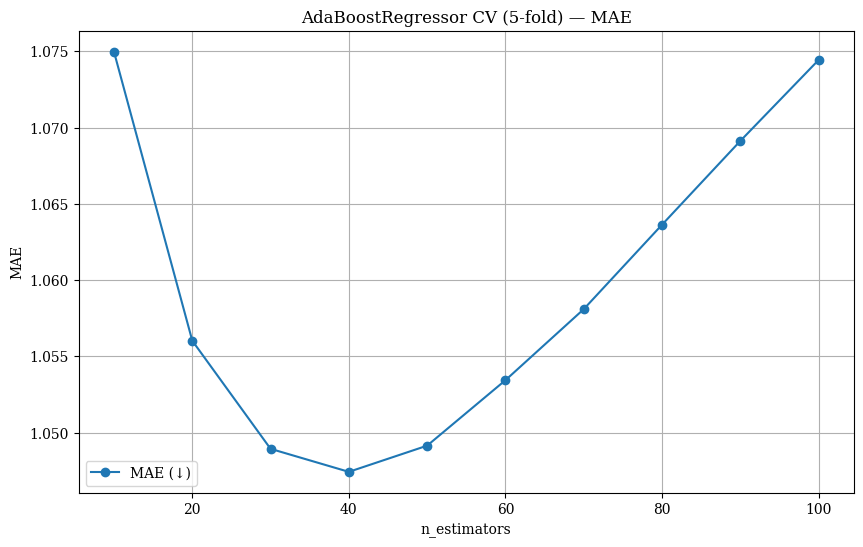


Hiệu năng AdaBoostRegressor trên tập validation:
- MAE : 1.1011
- RMSE: 1.3741
- R²  : 0.6061
[AB FE (CV+Val)] time=160.30s | Py-peak=42.5 MB | RSS(before/after/delta)=3405.0/2205.0/-1199.9 MB

Hiệu năng AdaBoostRegressor trên tập test:
- MAE : 1.0820
- RMSE: 1.3794
- R²  : 0.5459
[AB FE (Test)] time=0.01s | Py-peak=9.1 MB | RSS(before/after/delta)=2205.3/2208.3/3.1 MB
Best n_estimators theo MAE: 30 — MAE = 1.0759


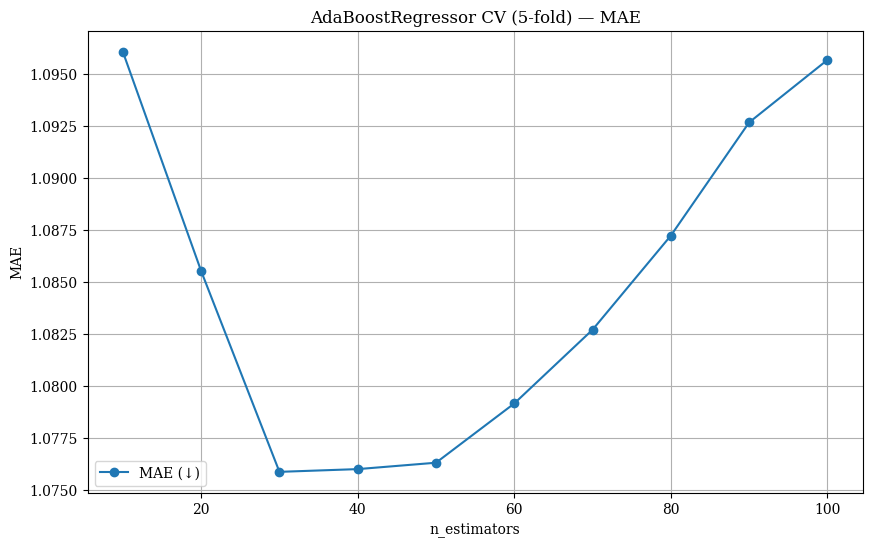


Hiệu năng AdaBoostRegressor trên tập validation:
- MAE : 1.2379
- RMSE: 1.5084
- R²  : 0.5209
[AB DT (CV+Val)] time=115.76s | Py-peak=40.2 MB | RSS(before/after/delta)=2208.3/1727.4/-480.9 MB

Hiệu năng AdaBoostRegressor trên tập test:
- MAE : 1.1302
- RMSE: 1.4548
- R²  : 0.4951
[AB DT (Test)] time=0.01s | Py-peak=6.3 MB | RSS(before/after/delta)=1727.5/1728.4/1.0 MB
Best n_estimators theo MAE: 30 — MAE = 1.0469


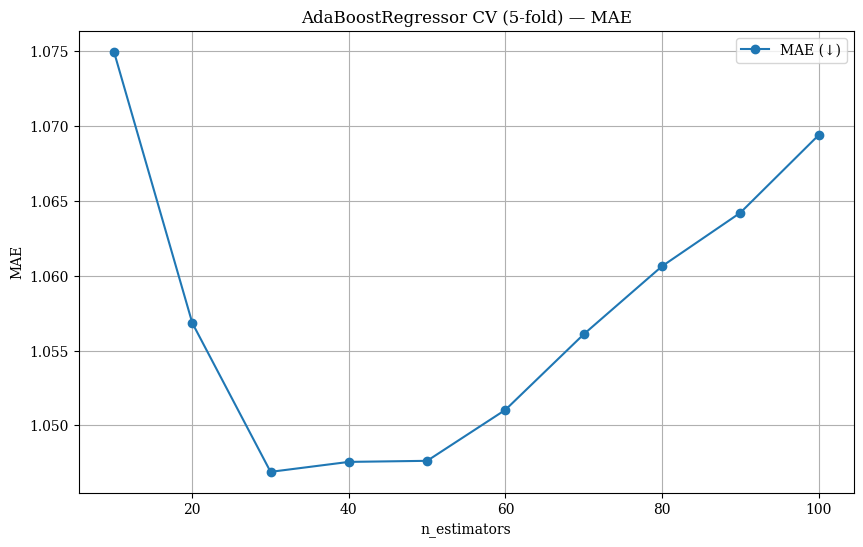


Hiệu năng AdaBoostRegressor trên tập validation:
- MAE : 1.0824
- RMSE: 1.3632
- R²  : 0.6124
[AB FE+DT (CV+Val)] time=183.07s | Py-peak=42.8 MB | RSS(before/after/delta)=1728.4/1727.6/-0.9 MB

Hiệu năng AdaBoostRegressor trên tập test:
- MAE : 1.0879
- RMSE: 1.3878
- R²  : 0.5403
[AB FE+DT (Test)] time=0.01s | Py-peak=6.2 MB | RSS(before/after/delta)=1727.6/1728.8/1.2 MB


,run,mae,rmse,r2,seconds,py_peak_mb,rss_before_mb,rss_after_mb,rss_delta_mb
0,AB Original (CV+Val),1.237942,1.508356,0.520942,129.924005,47.909936,3706.078125,3401.109375,-304.968750
1,AB Original (Test),1.130173,1.454844,0.495096,0.010749,6.273961,3401.203125,3404.968750,3.765625
2,AB FE (CV+Val),1.101130,1.374148,0.606080,160.300791,42.488269,3404.968750,2205.046875,-1199.921875
3,AB FE (Test),1.081978,1.379385,0.545853,0.012742,9.055980,2205.265625,2208.343750,3.078125
4,AB DT (CV+Val),1.237942,1.508356,0.520942,115.764754,40.228571,2208.343750,1727.421875,-480.921875
5,AB DT (Test),1.130173,1.454844,0.495096,0.009106,6.273730,1727.453125,1728.437500,0.984375
6,AB FE+DT (CV+Val),1.082367,1.363156,0.612357,183.069807,42.846156,1728.437500,1727.578125,-0.859375
7,AB FE+DT (Test),1.087912,1.387824,0.540278,0.010265,6.154674,1727.578125,1728.781250,1.203125


In [37]:
runs_ab = []

# 1) AB on Original Dataset (CV + Val)
(res1, stats1) = timed_mem_call(
    evaluate_val_ada_reg,
    X_train, y_train, X_val, y_val,
    label="AB Original (CV+Val)"
)
ab_model, ab_val_metrics, ab_info = res1
runs_ab.append({"run": "AB Original (CV+Val)", **ab_val_metrics, **stats1})

# Test
(res1t, stats1t) = timed_mem_call(
    evaluate_test_ada_reg,
    ab_model, X_test, y_test,
    label="AB Original (Test)"
)
ab_test_metrics = res1t
runs_ab.append({"run": "AB Original (Test)", **ab_test_metrics, **stats1t})

# 2) AB on FE Dataset (CV + Val)
(res2, stats2) = timed_mem_call(
    evaluate_val_ada_reg,
    X_fe_train, y_fe_train, X_fe_val, y_fe_val,
    label="AB FE (CV+Val)"
)
ab_fe_model, ab_val_fe_metrics, ab_fe_info = res2
runs_ab.append({"run": "AB FE (CV+Val)", **ab_val_fe_metrics, **stats2})

# Test
(res2t, stats2t) = timed_mem_call(
    evaluate_test_ada_reg,
    ab_fe_model, X_fe_test, y_fe_test,
    label="AB FE (Test)"
)
ab_test_fe_metrics = res2t
runs_ab.append({"run": "AB FE (Test)", **ab_test_fe_metrics, **stats2t})

# 3) AB on Original + DT (CV + Val)
(res3, stats3) = timed_mem_call(
    evaluate_val_ada_reg,
    X_dt_train, y_dt_train, X_dt_val, y_dt_val,
    label="AB DT (CV+Val)"
)
ab_dt_model, ab_val_dt_metrics, ab_dt_info = res3
runs_ab.append({"run": "AB DT (CV+Val)", **ab_val_dt_metrics, **stats3})

# Test
(res3t, stats3t) = timed_mem_call(
    evaluate_test_ada_reg,
    ab_dt_model, X_dt_test, y_dt_test,
    label="AB DT (Test)"
)
ab_test_dt_metrics = res3t
runs_ab.append({"run": "AB DT (Test)", **ab_test_dt_metrics, **stats3t})

# 4) AB on FE + DT (CV + Val)
(res4, stats4) = timed_mem_call(
    evaluate_val_ada_reg,
    X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val,
    label="AB FE+DT (CV+Val)"
)
ab_fe_dt_model, ab_val_fe_dt_metrics, ab_fe_dt_info = res4
runs_ab.append({"run": "AB FE+DT (CV+Val)", **ab_val_fe_dt_metrics, **stats4})

# Test
(res4t, stats4t) = timed_mem_call(
    evaluate_test_ada_reg,
    ab_fe_dt_model, X_fe_dt_test, y_fe_dt_test,
    label="AB FE+DT (Test)"
)
ab_test_fe_dt_metrics = res4t
runs_ab.append({"run": "AB FE+DT (Test)", **ab_test_fe_dt_metrics, **stats4t})

# DataFrame kết quả cho AB
df_runs_ab = pd.DataFrame(runs_ab)
display(df_runs_ab)

## 2.4. 📈 Ada Boost Performance Visualization
- Bar plots for Validation vs Test MAE
- Bar plots for Validation vs Test RMSE
- Bar plots for Validation vs Test R²

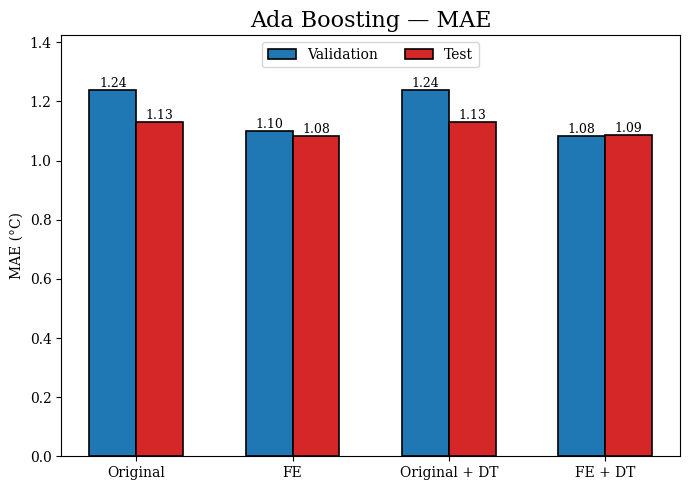

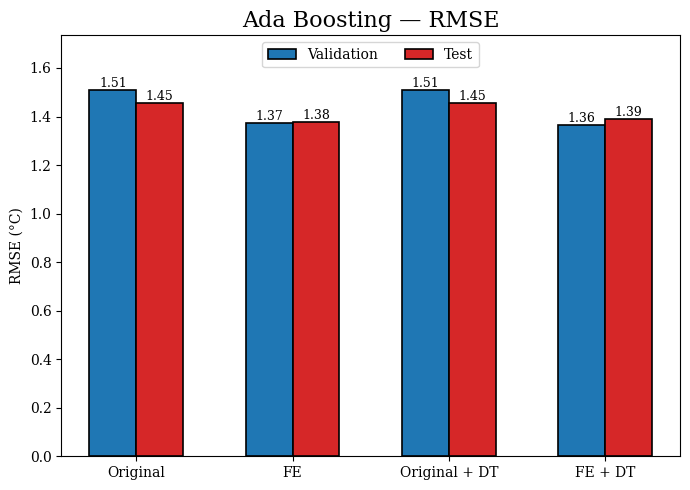

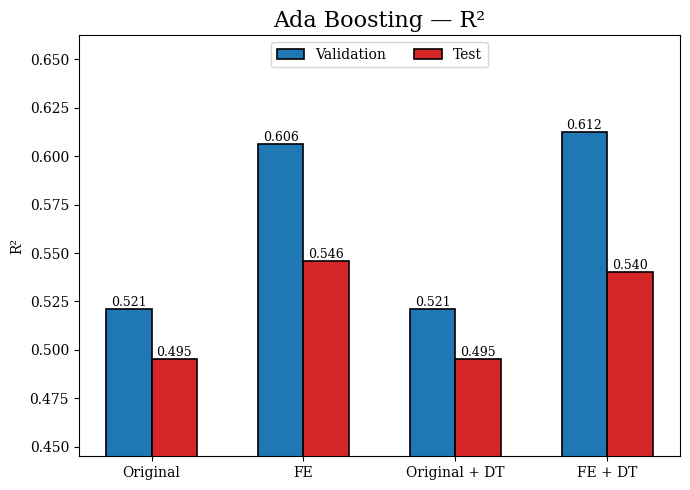

In [38]:
# MAE
plot_model_metrics(
    model_name='Ada Boosting',
    val_metric_dicts=[ab_val_metrics, ab_val_fe_metrics, ab_val_dt_metrics, ab_val_fe_dt_metrics],
    test_metric_dicts=[ab_test_metrics, ab_test_fe_metrics, ab_test_dt_metrics, ab_test_fe_dt_metrics],
    metric='mae'
)

# RMSE
plot_model_metrics(
    model_name='Ada Boosting',
    val_metric_dicts=[ab_val_metrics, ab_val_fe_metrics, ab_val_dt_metrics, ab_val_fe_dt_metrics],
    test_metric_dicts=[ab_test_metrics, ab_test_fe_metrics, ab_test_dt_metrics, ab_test_fe_dt_metrics],
    metric='rmse'
)

# R²
plot_model_metrics(
    model_name='Ada Boosting',
    val_metric_dicts=[ab_val_metrics, ab_val_fe_metrics, ab_val_dt_metrics, ab_val_fe_dt_metrics],
    test_metric_dicts=[ab_test_metrics, ab_test_fe_metrics, ab_test_dt_metrics, ab_test_fe_dt_metrics],
    metric='r2'
)

# **3. Gradient Boosting**

## 3.1. Find Optimal GB Function

In [39]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def find_optimal_gb_timeseries(
    X_train, y_train,
    n_estimators_range=range(50, 501, 50),
    cv_splits=6,
    gap=7,
    metric="mae",                  # 'mae' hoặc 'rmse'
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    random_state=SEED,
    plot=True
):
    """
    Tìm số lượng cây (n_estimators) tối ưu cho GradientBoostingRegressor
    với TimeSeriesSplit (có gap).
    Trả về: best_model, best_n, cv_table
    """
    # Chọn hàm đánh giá
    metric = metric.lower()
    if metric == "mae":
        scorer = lambda y_true, y_pred: mean_absolute_error(y_true, y_pred)
        ylabel = "CV MAE (↓ better)"
    elif metric == "rmse":
        scorer = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
        ylabel = "CV RMSE (↓ better)"
    else:
        raise ValueError("metric must be 'mae' or 'rmse'")

    # TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=cv_splits, gap=gap)
    ns = list(n_estimators_range)
    meds, stds = [], []

    # Chạy CV cho từng n_estimators
    for n in ns:
        fold_scores = []

        for tr_idx, va_idx in tscv.split(X_train):
            X_tr = X_train.iloc[tr_idx] if hasattr(X_train, "iloc") else X_train[tr_idx]
            X_va = X_train.iloc[va_idx] if hasattr(X_train, "iloc") else X_train[va_idx]
            y_tr = y_train.iloc[tr_idx] if hasattr(y_train, "iloc") else y_train[tr_idx]
            y_va = y_train.iloc[va_idx] if hasattr(y_train, "iloc") else y_train[va_idx]

            gb = GradientBoostingRegressor(
                n_estimators=n,
                learning_rate=learning_rate,
                max_depth=max_depth,
                subsample=subsample,
                random_state=random_state
            )
            gb.fit(X_tr, y_tr)
            pred = gb.predict(X_va)
            fold_scores.append(scorer(y_va, pred))

        meds.append(np.median(fold_scores))
        stds.append(np.std(fold_scores))

    # Chọn n_estimators tốt nhất
    best_idx = int(np.argmin(meds))
    best_n = ns[best_idx]

    print(f"[GB][CV] Best n_estimators = {best_n} | {ylabel.split()[0]} = "
          f"{meds[best_idx]:.4f} ± {stds[best_idx]:.4f}")

    # Vẽ biểu đồ
    if plot:
        plt.figure(figsize=(8,5))
        plt.errorbar(ns, meds, yerr=stds, fmt='o-', capsize=4)
        plt.title(f"Tối ưu n_estimators cho GradientBoosting (CV={cv_splits}, gap={gap})")
        plt.xlabel("n_estimators")
        plt.ylabel(ylabel)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    #  Huấn luyện mô hình tốt nhất trên toàn bộ train
    best_model = GradientBoostingRegressor(
        n_estimators=best_n,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        random_state=random_state
    )
    best_model.fit(X_train, y_train)

    cv_table = {
        "n_estimators": ns,
        "cv_median": meds,
        "cv_std": stds,
        "metric": metric
    }
    return best_model, best_n, cv_table

## 3.2. Evaluation Function

In [40]:
def evaluate_val_gb_reg(
    X_train, y_train, X_val, y_val,
    n_estimators_range=range(50, 501, 50),
    cv_splits=6, gap=7, metric="mae",
    learning_rate=0.1, max_depth=3, subsample=1.0,
    random_state=SEED, plot=True
):

    print('Tìm n_estimators tối ưu cho Gradient Boosting Regressor (TimeSeries)')

    model, best_n, cv_table = find_optimal_gb_timeseries(
        X_train, y_train,
        n_estimators_range=n_estimators_range,
        cv_splits=cv_splits, gap=gap, metric=metric,
        learning_rate=learning_rate, max_depth=max_depth, subsample=subsample,
        random_state=random_state, plot=plot
    )

    val_pred = model.predict(X_val)
    val_mae, val_rmse, val_r2 = _regression_scores(y_val, val_pred)

    print("\nHiệu năng trên Validation:")
    print(f"  MAE : {val_mae:.4f}")
    print(f"  RMSE: {val_rmse:.4f}")
    print(f"  R²  : {val_r2:.4f}")

    val_metrics = {"MAE": val_mae, "RMSE": val_rmse, "R2": val_r2}
    info = {"n_estimators": best_n, "cv": cv_table}
    return model, val_metrics, info


def evaluate_test_gb_reg(gb_model, X_test, y_test):

    test_pred = gb_model.predict(X_test)
    test_mae, test_rmse, test_r2 = _regression_scores(y_test, test_pred)

    print("\nHiệu năng trên Test:")
    print(f"  MAE : {test_mae:.4f}")
    print(f"  RMSE: {test_rmse:.4f}")
    print(f"  R²  : {test_r2:.4f}")

    return {"MAE": test_mae, "RMSE": test_rmse, "R2": test_r2}

## 3.3. 4-Way Evaluation of GradientBoosting

Tìm n_estimators tối ưu cho Gradient Boosting Regressor (TimeSeries)
[GB][CV] Best n_estimators = 500 | CV = 0.8960 ± 0.1671


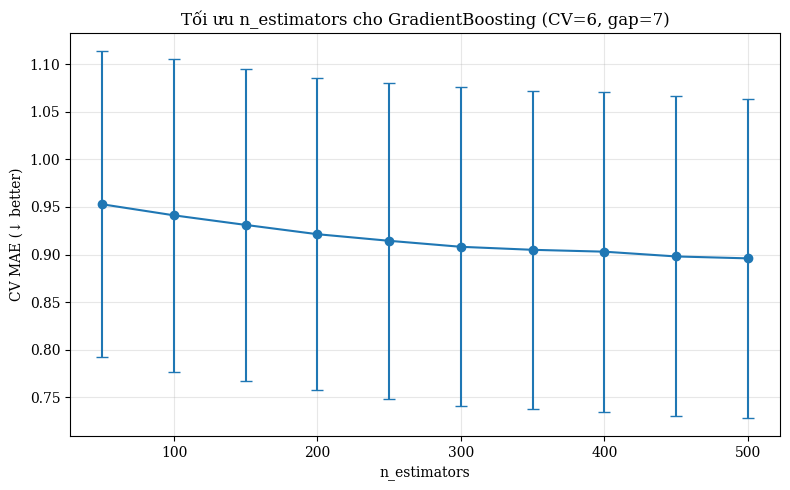


Hiệu năng trên Validation:
  MAE : 0.9479
  RMSE: 1.1944
  R²  : 0.6996
[GB Original (CV+Val)] time=710.46s | Py-peak=29.0 MB | RSS(before/after/delta)=1041.9/407.0/-634.9 MB

Hiệu năng trên Test:
  MAE : 1.0079
  RMSE: 1.3125
  R²  : 0.5890
[GB Original (Test)] time=0.01s | Py-peak=1.7 MB | RSS(before/after/delta)=416.7/420.3/3.6 MB
Tìm n_estimators tối ưu cho Gradient Boosting Regressor (TimeSeries)
[GB][CV] Best n_estimators = 500 | CV = 0.8339 ± 0.1075


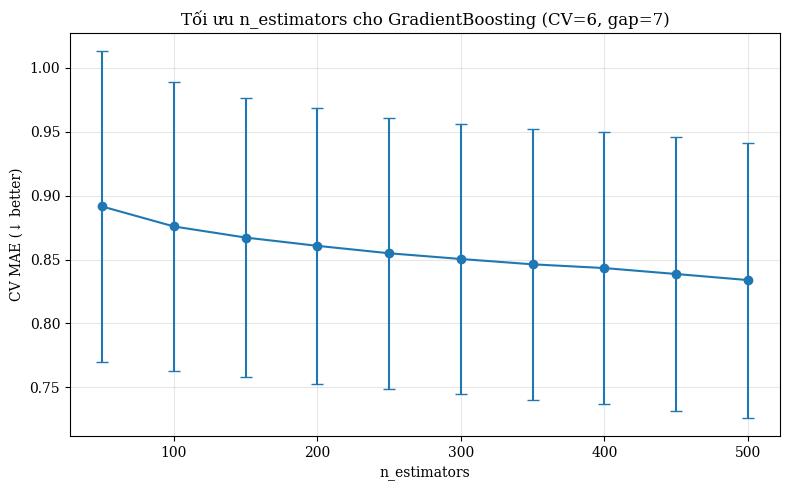


Hiệu năng trên Validation:
  MAE : 0.9439
  RMSE: 1.2095
  R²  : 0.6948
[GB FE (CV+Val)] time=975.02s | Py-peak=24.5 MB | RSS(before/after/delta)=420.3/367.6/-52.8 MB

Hiệu năng trên Test:
  MAE : 0.9986
  RMSE: 1.3036
  R²  : 0.5944
[GB FE (Test)] time=0.01s | Py-peak=1.4 MB | RSS(before/after/delta)=377.0/378.2/1.1 MB
Tìm n_estimators tối ưu cho Gradient Boosting Regressor (TimeSeries)
[GB][CV] Best n_estimators = 500 | CV = 0.8540 ± 0.1333


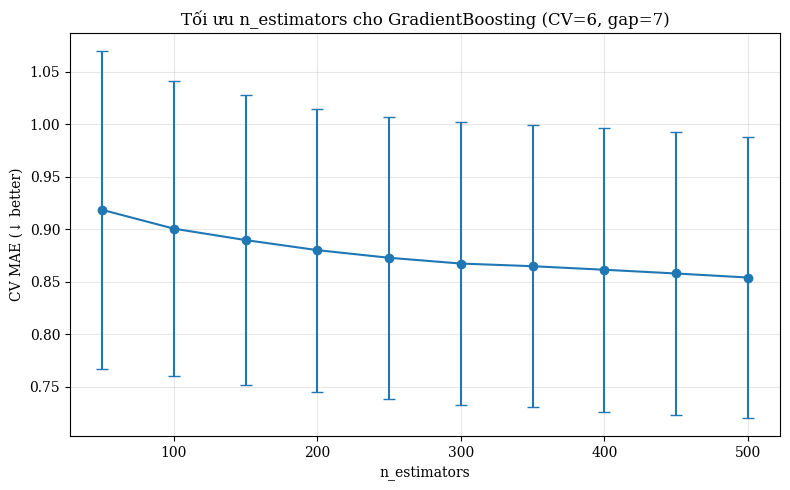


Hiệu năng trên Validation:
  MAE : 0.9329
  RMSE: 1.1935
  R²  : 0.7001
[GB DT (CV+Val)] time=662.55s | Py-peak=17.4 MB | RSS(before/after/delta)=378.2/387.5/9.3 MB

Hiệu năng trên Test:
  MAE : 1.0265
  RMSE: 1.3407
  R²  : 0.5712
[GB DT (Test)] time=0.01s | Py-peak=0.9 MB | RSS(before/after/delta)=445.8/446.8/0.9 MB
Tìm n_estimators tối ưu cho Gradient Boosting Regressor (TimeSeries)
[GB][CV] Best n_estimators = 500 | CV = 0.8133 ± 0.1226


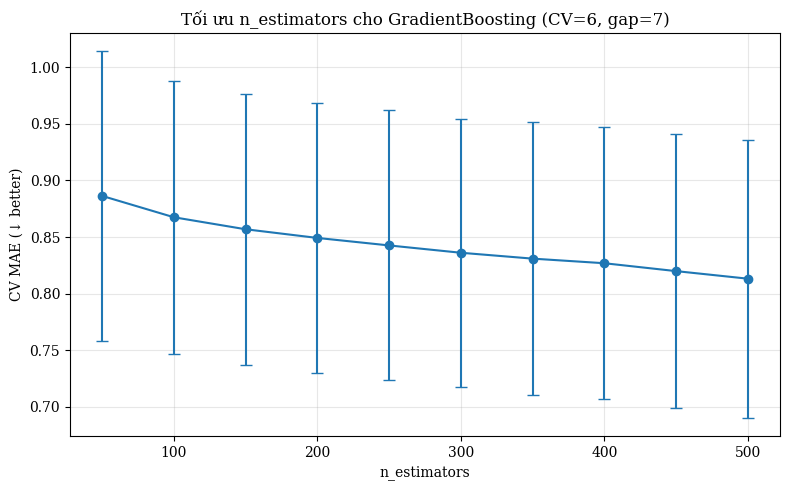


Hiệu năng trên Validation:
  MAE : 0.9308
  RMSE: 1.1957
  R²  : 0.7018
[GB FE+DT (CV+Val)] time=1106.44s | Py-peak=21.5 MB | RSS(before/after/delta)=446.8/351.0/-95.7 MB

Hiệu năng trên Test:
  MAE : 0.9927
  RMSE: 1.2924
  R²  : 0.6013
[GB FE+DT (Test)] time=0.01s | Py-peak=1.1 MB | RSS(before/after/delta)=394.7/396.2/1.5 MB


,run,MAE,RMSE,R2,seconds,py_peak_mb,rss_before_mb,rss_after_mb,rss_delta_mb
0,GB Original (CV+Val),0.947880,1.194442,0.699593,710.460247,28.985513,1041.890625,406.968750,-634.921875
1,GB Original (Test),1.007854,1.312546,0.589035,0.013648,1.708059,416.703125,420.343750,3.640625
2,GB FE (CV+Val),0.943928,1.209522,0.694812,975.024371,24.508110,420.343750,367.562500,-52.781250
3,GB FE (Test),0.998603,1.303610,0.594378,0.012987,1.405729,377.046875,378.187500,1.140625
4,GB DT (CV+Val),0.932921,1.193477,0.700078,662.549783,17.437740,378.187500,387.453125,9.265625
5,GB DT (Test),1.026514,1.340660,0.571241,0.012700,0.856146,445.828125,446.750000,0.921875
6,GB FE+DT (CV+Val),0.930836,1.195666,0.701764,1106.436374,21.463629,446.750000,351.031250,-95.718750
7,GB FE+DT (Test),0.992685,1.292444,0.601297,0.013312,1.134497,394.671875,396.171875,1.500000


In [41]:
runs_gb = []

# 1) GB on Original Dataset (CV + Val)
(res1, stats1) = timed_mem_call(
    evaluate_val_gb_reg,
    X_train, y_train, X_val, y_val,
    label="GB Original (CV+Val)"
)
gb_model, gb_val_metrics, gb_info = res1
runs_gb.append({"run": "GB Original (CV+Val)", **gb_val_metrics, **stats1})

# Test
(res1t, stats1t) = timed_mem_call(
    evaluate_test_gb_reg,
    gb_model, X_test, y_test,
    label="GB Original (Test)"
)
gb_test_metrics = res1t
runs_gb.append({"run": "GB Original (Test)", **gb_test_metrics, **stats1t})


# 2) GB on FE Dataset (CV + Val)
(res2, stats2) = timed_mem_call(
    evaluate_val_gb_reg,
    X_fe_train, y_fe_train, X_fe_val, y_fe_val,
    label="GB FE (CV+Val)"
)
gb_fe_model, gb_val_fe_metrics, gb_fe_info = res2
runs_gb.append({"run": "GB FE (CV+Val)", **gb_val_fe_metrics, **stats2})

# Test
(res2t, stats2t) = timed_mem_call(
    evaluate_test_gb_reg,
    gb_fe_model, X_fe_test, y_fe_test,
    label="GB FE (Test)"
)
gb_test_fe_metrics = res2t
runs_gb.append({"run": "GB FE (Test)", **gb_test_fe_metrics, **stats2t})


# 3) GB on Original + DT (CV + Val)
(res3, stats3) = timed_mem_call(
    evaluate_val_gb_reg,
    X_dt_train, y_dt_train, X_dt_val, y_dt_val,
    label="GB DT (CV+Val)"
)
gb_dt_model, gb_val_dt_metrics, gb_dt_info = res3
runs_gb.append({"run": "GB DT (CV+Val)", **gb_val_dt_metrics, **stats3})

# Test
(res3t, stats3t) = timed_mem_call(
    evaluate_test_gb_reg,
    gb_dt_model, X_dt_test, y_dt_test,
    label="GB DT (Test)"
)
gb_test_dt_metrics = res3t
runs_gb.append({"run": "GB DT (Test)", **gb_test_dt_metrics, **stats3t})


# 4) GB on FE + DT (CV + Val)
(res4, stats4) = timed_mem_call(
    evaluate_val_gb_reg,
    X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val,
    label="GB FE+DT (CV+Val)"
)
gb_fe_dt_model, gb_val_fe_dt_metrics, gb_fe_dt_info = res4
runs_gb.append({"run": "GB FE+DT (CV+Val)", **gb_val_fe_dt_metrics, **stats4})

# Test
(res4t, stats4t) = timed_mem_call(
    evaluate_test_gb_reg,
    gb_fe_dt_model, X_fe_dt_test, y_fe_dt_test,
    label="GB FE+DT (Test)"
)
gb_test_fe_dt_metrics = res4t
runs_gb.append({"run": "GB FE+DT (Test)", **gb_test_fe_dt_metrics, **stats4t})


# DataFrame kết quả cho GB
df_runs_gb = pd.DataFrame(runs_gb)
display(df_runs_gb)

## 3.4. 📈 Gradient Boosting Performance Visualization
- Bar plots for Validation vs Test MAE
- Bar plots for Validation vs Test RMSE
- Bar plots for Validation vs Test R²

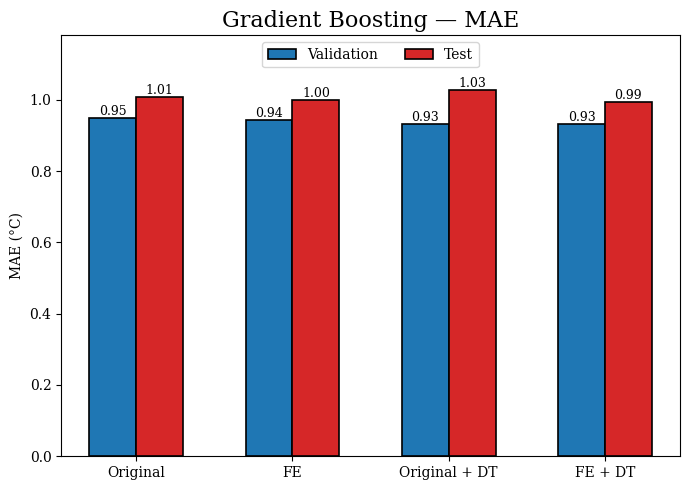

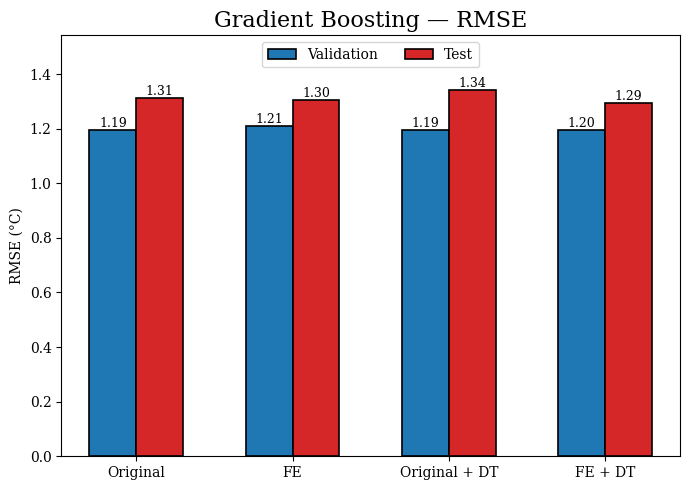

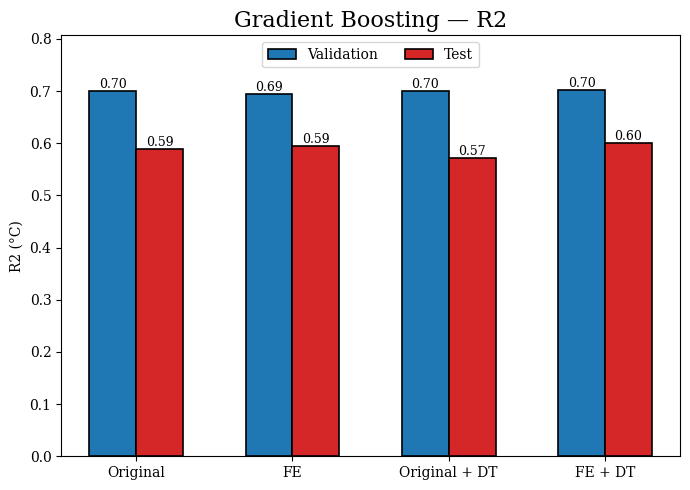

In [42]:
# MAE
plot_model_metrics(
    model_name='Gradient Boosting',
    val_metric_dicts=[gb_val_metrics, gb_val_fe_metrics, gb_val_dt_metrics, gb_val_fe_dt_metrics],
    test_metric_dicts=[gb_test_metrics, gb_test_fe_metrics, gb_test_dt_metrics, gb_test_fe_dt_metrics],
    metric='MAE'
)

# RMSE
plot_model_metrics(
    model_name='Gradient Boosting',
    val_metric_dicts=[gb_val_metrics, gb_val_fe_metrics, gb_val_dt_metrics, gb_val_fe_dt_metrics],
    test_metric_dicts=[gb_test_metrics, gb_test_fe_metrics, gb_test_dt_metrics, gb_test_fe_dt_metrics],
    metric='RMSE'
)

# R²
plot_model_metrics(
    model_name='Gradient Boosting',
    val_metric_dicts=[gb_val_metrics, gb_val_fe_metrics, gb_val_dt_metrics, gb_val_fe_dt_metrics],
    test_metric_dicts=[gb_test_metrics, gb_test_fe_metrics, gb_test_dt_metrics, gb_test_fe_dt_metrics],
    metric='R2'
)

# **4. XGBoost**

## 4.1. Find Optimal XGB Function

In [43]:
def find_optimal_xgb_reg(
    X_train, y_train,
    n_estimators_range=5000,           # int -> Manual-ES ; iterable -> Sweep
    cv_splits=5,
    gap=7,
    test_size=None,
    main_metric='MAE',
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    min_child_weight=1.0,
    use_gpu=False
):
    # CV splitter
    cv = TimeSeriesSplit(n_splits=cv_splits, gap=gap, test_size=test_size) \
         if test_size is not None else TimeSeriesSplit(n_splits=cv_splits, gap=gap)

    tree_method = 'gpu_hist' if use_gpu else 'hist'
    base_kwargs = dict(
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
        min_child_weight=min_child_weight,
        objective='reg:squarederror',
        random_state=SEED,
        n_jobs=-1,
        tree_method=tree_method,
        verbosity=0
    )

    main_metric = main_metric.upper()
    assert main_metric in {'MAE','RMSE','R2','R^2','R²'}

    # MODE A: MANUAL EARLY-STOPPING
    if isinstance(n_estimators_range, int):
        max_estimators = int(n_estimators_range)
        fold_best_n, fold_mae, fold_rmse, fold_r2 = [], [], [], []

        print(">>> Manual-ES mode: Huấn luyện full và tự chọn best_iter")

        for fold_idx, (tr_idx, va_idx) in enumerate(cv.split(X_train), start=1):
            X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
            y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

            es_metric = 'mae' if main_metric=='MAE' else 'rmse'
            model = XGBRegressor(
                n_estimators=max_estimators,
                eval_metric=es_metric,
                **base_kwargs
            )

            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

            # Lấy đường cong metric từ evals_result_
            res = model.evals_result()
            metric_curve = res['validation_0'][es_metric]
            best_iter = int(np.argmin(metric_curve))
            fold_best_n.append(best_iter+1)

            # --- VẼ PLOT CHO FOLD 1 (hoặc mọi fold nếu muốn)
            if fold_idx == 1:
                plt.figure(figsize=(8,5))
                plt.plot(metric_curve, label=f'Fold {fold_idx} - val {es_metric.upper()}')
                plt.axvline(best_iter, color='r', linestyle='--', label='Best Iter')
                plt.xlabel('Epoch')
                plt.ylabel(es_metric.upper())
                plt.title('Đường cong MAE/RMSE theo Epoch (Fold 1)')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.show()

            # Dự báo với best_iter
            y_hat = model.predict(X_va, iteration_range=(0, best_iter+1))
            mae, rmse, r2 = _regression_scores(y_va, y_hat)
            fold_mae.append(mae); fold_rmse.append(rmse); fold_r2.append(r2)

        # Kết quả trung bình
        val_mae = np.mean(fold_mae)
        val_rmse = np.mean(fold_rmse)
        val_r2 = np.mean(fold_r2)
        best_n = int(np.median(fold_best_n))

        print(f"[XGBRegressor][Manual-ES] best_n≈{best_n} | "
              f"MAE={val_mae:.4f} | RMSE={val_rmse:.4f} | R²={val_r2:.4f}")

        # Huấn luyện lại trên toàn train
        best_model = XGBRegressor(
            n_estimators=best_n,
            eval_metric='mae' if main_metric=='MAE' else 'rmse',
            **base_kwargs
        )
        best_model.fit(X_train, y_train, verbose=False)

        chosen_score = val_mae if main_metric=='MAE' else \
                       val_rmse if main_metric=='RMSE' else val_r2

        return best_model, best_n, chosen_score, {
            'mode':'manual_es',
            'fold_best_n':fold_best_n,
            'mae':[val_mae],
            'rmse':[val_rmse],
            'r2':[val_r2]
        }

    # MODE B: SWEEP
    n_list = list(n_estimators_range)
    all_mae, all_rmse, all_r2 = [], [], []

    for n in n_list:
        f_mae, f_rmse, f_r2 = [], [], []

        for tr_idx, va_idx in cv.split(X_train):
            X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
            y_tr, y_va = y_train.iloc[tr_idx], y_train.iloc[va_idx]

            model = XGBRegressor(n_estimators=int(n), **base_kwargs)
            model.fit(X_tr, y_tr, verbose=False)
            y_hat = model.predict(X_va)

            mae, rmse, r2 = _regression_scores(y_va, y_hat)
            f_mae.append(mae); f_rmse.append(rmse); f_r2.append(r2)

        all_mae.append(np.mean(f_mae))
        all_rmse.append(np.mean(f_rmse))
        all_r2.append(np.mean(f_r2))

    if main_metric=='MAE':
        best_idx, scores, ylabel = int(np.argmin(all_mae)), all_mae, 'MAE (°C)'
    elif main_metric=='RMSE':
        best_idx, scores, ylabel = int(np.argmin(all_rmse)), all_rmse, 'RMSE (°C)'
    else:
        best_idx, scores, ylabel = int(np.argmax(all_r2)), all_r2, 'R²'

    best_n = int(n_list[best_idx])
    print(f"[XGBRegressor][Sweep] best_n={best_n} | {main_metric}={scores[best_idx]:.4f}")

    # Vẽ đường cong chọn n_estimators
    plt.figure(figsize=(8,5))
    plt.plot(n_list, scores, 'o-', linewidth=2)
    plt.xlabel('n_estimators'); plt.ylabel(ylabel)
    plt.title(f'Chọn n_estimators tối ưu — {main_metric}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    best_model = XGBRegressor(n_estimators=best_n, **base_kwargs)
    best_model.fit(X_train, y_train, verbose=False)

    return best_model, best_n, scores[best_idx], {
        'mode':'sweep',
        'n_estimators':n_list,
        'mae':all_mae,
        'rmse':all_rmse,
        'r2':all_r2
    }

## 4.2. Evaluation Function 

In [44]:
def evaluate_val_xgb_reg(
    X_train, y_train, X_val, y_val,
    n_estimators_range=5000,
    cv_splits=5,
    gap=7,
    test_size=None,
    main_metric='MAE',
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    min_child_weight=1.0,
    use_gpu=False
):
    print("Tìm n_estimators tối ưu cho XGBRegressor ...")

    best_model, best_n, cv_best_score, cv_history = find_optimal_xgb_reg(
        X_train, y_train,
        n_estimators_range=n_estimators_range,
        cv_splits=cv_splits,
        gap=gap,
        test_size=test_size,
        main_metric=main_metric,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
        min_child_weight=min_child_weight,
        use_gpu=use_gpu
    )

    val_pred = best_model.predict(X_val)
    val_mae, val_rmse, val_r2 = _regression_scores(y_val, val_pred)
    print(f"Validation: MAE={val_mae:.4f} | RMSE={val_rmse:.4f} | R²={val_r2:.4f}")

    return best_model, {"MAE":val_mae,"RMSE":val_rmse,"R2":val_r2}, {
        "n_estimators":best_n,
        "cv_best_score":cv_best_score,
        "cv_history":cv_history
    }


def evaluate_test_xgb_reg(model, X_test, y_test):
    pred = model.predict(X_test)
    mae, rmse, r2 = _regression_scores(y_test, pred)
    print(f"Test: MAE={mae:.4f} | RMSE={rmse:.4f} | R²={r2:.4f}")
    return {"MAE":mae, "RMSE":rmse, "R2":r2}

## 4.3. 4-Way Evaluation of XGBoost
- Original Dataset
- Feature-Engineered (FE) Dataset
- Original + Decision Tree (DT) Selected Features
- FE + DT

Tìm n_estimators tối ưu cho XGBRegressor ...
>>> Manual-ES mode: Huấn luyện full và tự chọn best_iter


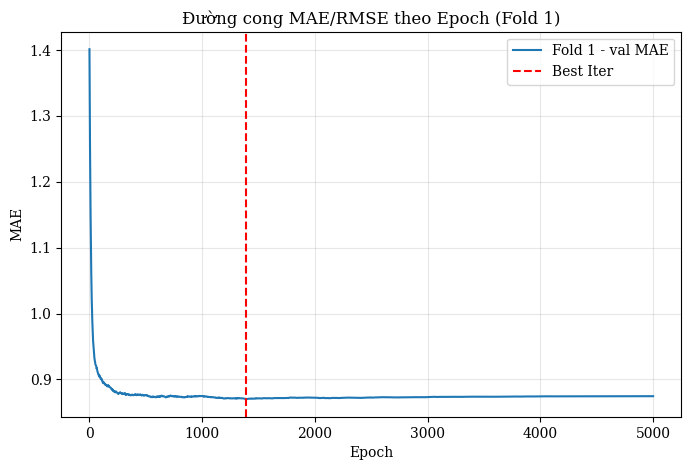

[XGBRegressor][Manual-ES] best_n≈4990 | MAE=0.7173 | RMSE=1.0152 | R²=0.7323
Validation: MAE=1.0714 | RMSE=1.3545 | R²=0.6137
[XGB Original (CV+Val)] time=96.90s | Py-peak=31.6 MB | RSS(before/after/delta)=445.6/743.3/297.7 MB
Test: MAE=1.0491 | RMSE=1.3676 | R²=0.5538
[XGB Original (Test)] time=0.05s | Py-peak=0.3 MB | RSS(before/after/delta)=743.2/744.2/0.9 MB
Tìm n_estimators tối ưu cho XGBRegressor ...
>>> Manual-ES mode: Huấn luyện full và tự chọn best_iter


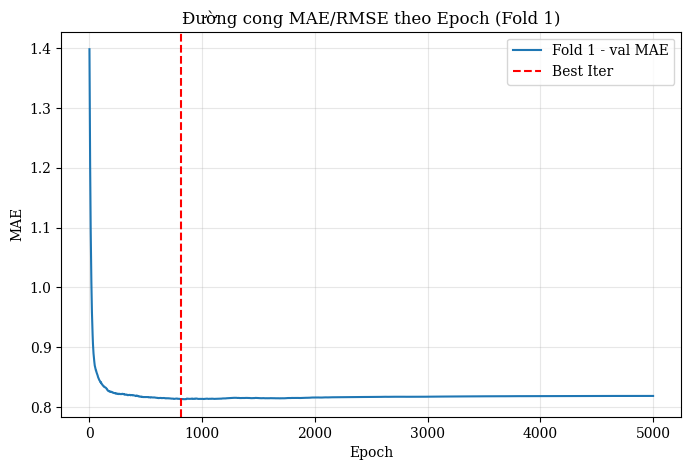

[XGBRegressor][Manual-ES] best_n≈5000 | MAE=0.5581 | RMSE=0.8294 | R²=0.8147
Validation: MAE=1.0039 | RMSE=1.2796 | R²=0.6584
[XGB FE (CV+Val)] time=79.83s | Py-peak=19.1 MB | RSS(before/after/delta)=744.2/826.4/82.3 MB
Test: MAE=1.0461 | RMSE=1.3618 | R²=0.5574
[XGB FE (Test)] time=0.03s | Py-peak=0.2 MB | RSS(before/after/delta)=826.4/827.4/1.0 MB
Tìm n_estimators tối ưu cho XGBRegressor ...
>>> Manual-ES mode: Huấn luyện full và tự chọn best_iter


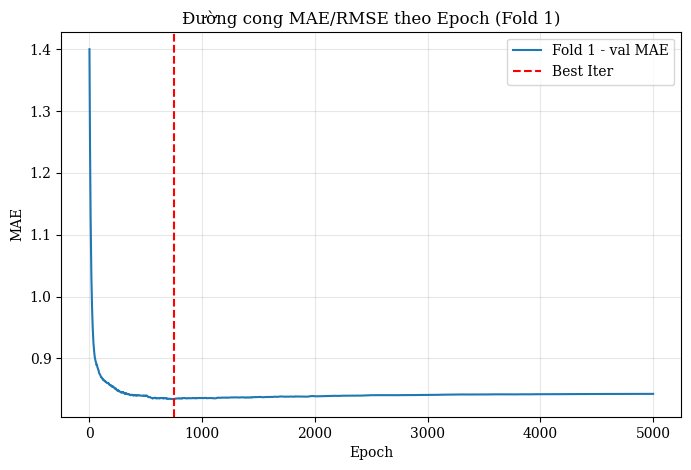

[XGBRegressor][Manual-ES] best_n≈4999 | MAE=0.6326 | RMSE=0.9173 | R²=0.7788
Validation: MAE=0.9772 | RMSE=1.2663 | R²=0.6623
[XGB DT (CV+Val)] time=78.94s | Py-peak=17.5 MB | RSS(before/after/delta)=827.4/934.9/107.5 MB
Test: MAE=1.0675 | RMSE=1.3979 | R²=0.5339
[XGB DT (Test)] time=0.04s | Py-peak=0.2 MB | RSS(before/after/delta)=934.9/934.9/0.0 MB
Tìm n_estimators tối ưu cho XGBRegressor ...
>>> Manual-ES mode: Huấn luyện full và tự chọn best_iter


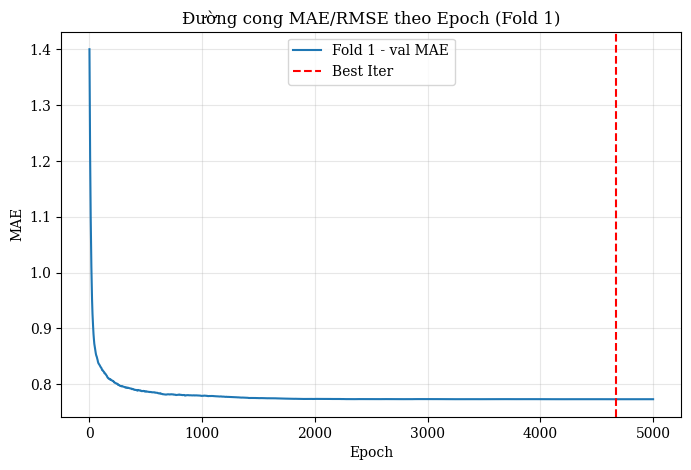

[XGBRegressor][Manual-ES] best_n≈5000 | MAE=0.5267 | RMSE=0.7915 | R²=0.8294
Validation: MAE=0.9830 | RMSE=1.2548 | R²=0.6715
[XGB FE+DT (CV+Val)] time=82.31s | Py-peak=22.4 MB | RSS(before/after/delta)=934.9/980.4/45.5 MB
Test: MAE=1.0457 | RMSE=1.3546 | R²=0.5620
[XGB FE+DT (Test)] time=0.04s | Py-peak=0.2 MB | RSS(before/after/delta)=980.4/980.4/0.0 MB


,run,MAE,RMSE,R2,seconds,py_peak_mb,rss_before_mb,rss_after_mb,rss_delta_mb
0,XGB Original (CV+Val),1.071386,1.354536,0.613668,96.903319,31.602159,445.609375,743.265625,297.656250
1,XGB Original (Test),1.049079,1.367619,0.553824,0.046044,0.257816,743.218750,744.156250,0.937500
2,XGB FE (CV+Val),1.003902,1.279597,0.658424,79.829172,19.131860,744.156250,826.421875,82.265625
3,XGB FE (Test),1.046099,1.361775,0.557374,0.034930,0.222801,826.421875,827.437500,1.015625
4,XGB DT (CV+Val),0.977171,1.266347,0.662335,78.943438,17.468526,827.437500,934.890625,107.453125
5,XGB DT (Test),1.067532,1.397854,0.533878,0.039317,0.222294,934.890625,934.890625,0.000000
6,XGB FE+DT (CV+Val),0.983034,1.254838,0.671515,82.305680,22.418412,934.890625,980.406250,45.515625
7,XGB FE+DT (Test),1.045731,1.354582,0.562038,0.037500,0.231747,980.406250,980.406250,0.000000


In [46]:
runs_xgb = []

# 1) XGB on Original Dataset (CV + Val)
(res1, stats1) = timed_mem_call(
    evaluate_val_xgb_reg,
    X_train, y_train, X_val, y_val,
    label="XGB Original (CV+Val)"
)
xgb_model, xgb_val_metrics, xgb_info = res1
runs_xgb.append({"run": "XGB Original (CV+Val)", **xgb_val_metrics, **stats1})

# Test
(res1t, stats1t) = timed_mem_call(
    evaluate_test_xgb_reg,
    xgb_model, X_test, y_test,
    label="XGB Original (Test)"
)
xgb_test_metrics = res1t
runs_xgb.append({"run": "XGB Original (Test)", **xgb_test_metrics, **stats1t})


# 2) XGB on FE Dataset (CV + Val)
(res2, stats2) = timed_mem_call(
    evaluate_val_xgb_reg,
    X_fe_train, y_fe_train, X_fe_val, y_fe_val,
    label="XGB FE (CV+Val)"
)
xgb_fe_model, xgb_val_fe_metrics, xgb_fe_info = res2
runs_xgb.append({"run": "XGB FE (CV+Val)", **xgb_val_fe_metrics, **stats2})

# Test
(res2t, stats2t) = timed_mem_call(
    evaluate_test_xgb_reg,
    xgb_fe_model, X_fe_test, y_fe_test,
    label="XGB FE (Test)"
)
xgb_test_fe_metrics = res2t
runs_xgb.append({"run": "XGB FE (Test)", **xgb_test_fe_metrics, **stats2t})


# 3) XGB on Original + DT (CV + Val)
(res3, stats3) = timed_mem_call(
    evaluate_val_xgb_reg,
    X_dt_train, y_dt_train, X_dt_val, y_dt_val,
    label="XGB DT (CV+Val)"
)
xgb_dt_model, xgb_val_dt_metrics, xgb_dt_info = res3
runs_xgb.append({"run": "XGB DT (CV+Val)", **xgb_val_dt_metrics, **stats3})

# Test
(res3t, stats3t) = timed_mem_call(
    evaluate_test_xgb_reg,
    xgb_dt_model, X_dt_test, y_dt_test,
    label="XGB DT (Test)"
)
xgb_test_dt_metrics = res3t
runs_xgb.append({"run": "XGB DT (Test)", **xgb_test_dt_metrics, **stats3t})


# 4) XGB on FE + DT (CV + Val)
(res4, stats4) = timed_mem_call(
    evaluate_val_xgb_reg,
    X_fe_dt_train, y_fe_dt_train, X_fe_dt_val, y_fe_dt_val,
    label="XGB FE+DT (CV+Val)"
)
xgb_fe_dt_model, xgb_val_fe_dt_metrics, xgb_fe_dt_info = res4
runs_xgb.append({"run": "XGB FE+DT (CV+Val)", **xgb_val_fe_dt_metrics, **stats4})

# Test
(res4t, stats4t) = timed_mem_call(
    evaluate_test_xgb_reg,
    xgb_fe_dt_model, X_fe_dt_test, y_fe_dt_test,
    label="XGB FE+DT (Test)"
)
xgb_test_fe_dt_metrics = res4t
runs_xgb.append({"run": "XGB FE+DT (Test)", **xgb_test_fe_dt_metrics, **stats4t})

# DataFrame kết quả cho XGB
df_runs_xgb = pd.DataFrame(runs_xgb)
display(df_runs_xgb)

## 4.4. 📈 XGBoost Performance Visualization
- Bar plots for Validation vs Test MAE
- Bar plots for Validation vs Test RMSE
- Bar plots for Validation vs Test R²

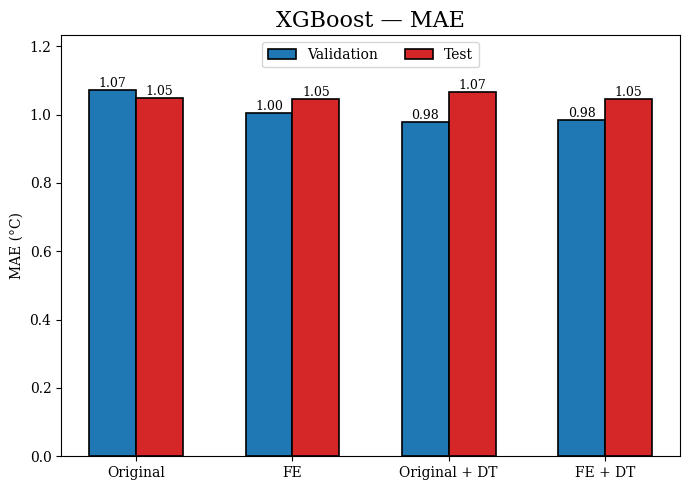

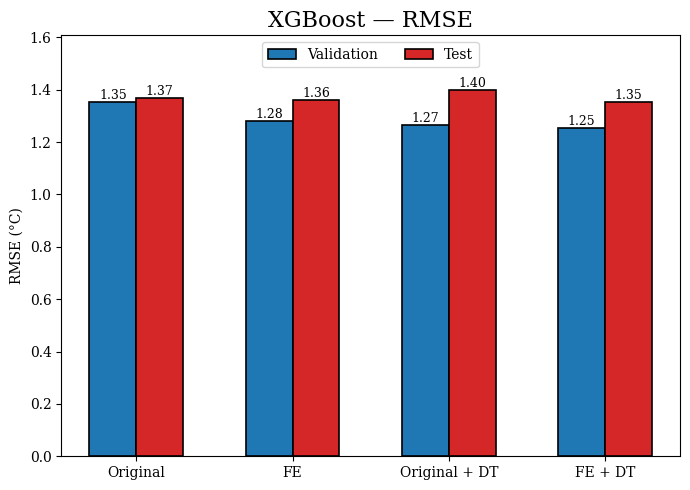

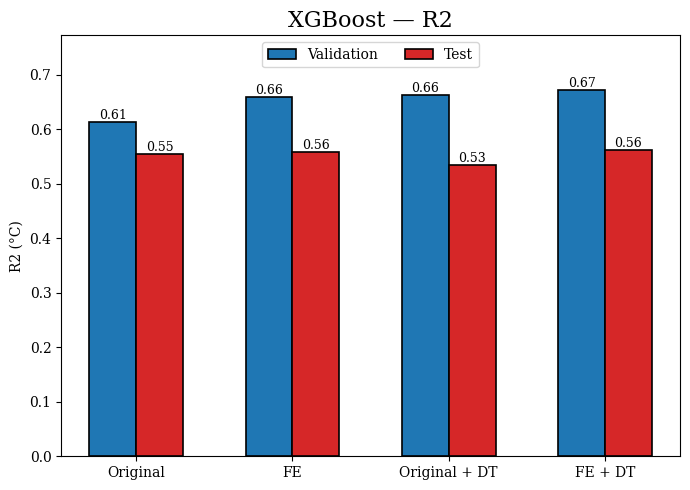

In [48]:
# MAE
plot_model_metrics(
    model_name='XGBoost',
    val_metric_dicts=[xgb_val_metrics, xgb_val_fe_metrics, xgb_val_dt_metrics, xgb_val_fe_dt_metrics],
    test_metric_dicts=[xgb_test_metrics, xgb_test_fe_metrics, xgb_test_dt_metrics, xgb_test_fe_dt_metrics],
    metric='MAE'
)

# RMSE
plot_model_metrics(
    model_name='XGBoost',
    val_metric_dicts=[xgb_val_metrics, xgb_val_fe_metrics, xgb_val_dt_metrics, xgb_val_fe_dt_metrics],
    test_metric_dicts=[xgb_test_metrics, xgb_test_fe_metrics, xgb_test_dt_metrics, xgb_test_fe_dt_metrics],
    metric='RMSE'
)

# R²
plot_model_metrics(
    model_name='XGBoost',
    val_metric_dicts=[xgb_val_metrics, xgb_val_fe_metrics, xgb_val_dt_metrics, xgb_val_fe_dt_metrics],
    test_metric_dicts=[xgb_test_metrics, xgb_test_fe_metrics, xgb_test_dt_metrics, xgb_test_fe_dt_metrics],
    metric='R2'
)

# 5. Comprehensive Model Comparison & Analysis


In [49]:
# 5.1. Create Comprehensive Results Summary
print("COMPREHENSIVE MODEL PERFORMANCE SUMMARY")

def metric_lookup(metrics_dict, metric, prefix=None):
    metric_variants = {
        metric,
        metric.lower(),
        metric.upper(),
        metric.capitalize()
    }
    candidates = []
    if prefix:
        prefix_variants = {
            prefix,
            prefix.lower(),
            prefix.upper(),
            prefix.capitalize()
        }
        for pref in prefix_variants:
            for met in list(metric_variants):
                candidates.append(f"{pref}_{met}")
                candidates.append(f"{pref}_{met.lower()}")
    candidates.extend(metric_variants)
    for key in candidates:
        if key in metrics_dict:
            return metrics_dict[key]
    raise KeyError(f"Metric '{metric}' not found in keys: {list(metrics_dict.keys())}")

datasets = ['Original', 'FE', 'Original + DT', 'FE + DT']

xgb_results = {
    'Dataset': datasets,
    'Model': ['XGBoost'] * len(datasets),
    'Val_MAE': [metric_lookup(d, 'mae', prefix='val') for d in [xgb_val_metrics, xgb_val_fe_metrics, xgb_val_dt_metrics, xgb_val_fe_dt_metrics]],
    'Test_MAE': [metric_lookup(d, 'mae', prefix='test') for d in [xgb_test_metrics, xgb_test_fe_metrics, xgb_test_dt_metrics, xgb_test_fe_dt_metrics]],
    'Val_RMSE': [metric_lookup(d, 'rmse', prefix='val') for d in [xgb_val_metrics, xgb_val_fe_metrics, xgb_val_dt_metrics, xgb_val_fe_dt_metrics]],
    'Test_RMSE': [metric_lookup(d, 'rmse', prefix='test') for d in [xgb_test_metrics, xgb_test_fe_metrics, xgb_test_dt_metrics, xgb_test_fe_dt_metrics]],
    'Val_R2': [metric_lookup(d, 'r2', prefix='val') for d in [xgb_val_metrics, xgb_val_fe_metrics, xgb_val_dt_metrics, xgb_val_fe_dt_metrics]],
    'Test_R2': [metric_lookup(d, 'r2', prefix='test') for d in [xgb_test_metrics, xgb_test_fe_metrics, xgb_test_dt_metrics, xgb_test_fe_dt_metrics]]
}

gb_results = {
    'Dataset': datasets,
    'Model': ['Gradient Boosting'] * len(datasets),
    'Val_MAE': [metric_lookup(d, 'mae', prefix='val') for d in [gb_val_metrics, gb_val_fe_metrics, gb_val_dt_metrics, gb_val_fe_dt_metrics]],
    'Test_MAE': [metric_lookup(d, 'mae', prefix='test') for d in [gb_test_metrics, gb_test_fe_metrics, gb_test_dt_metrics, gb_test_fe_dt_metrics]],
    'Val_RMSE': [metric_lookup(d, 'rmse', prefix='val') for d in [gb_val_metrics, gb_val_fe_metrics, gb_val_dt_metrics, gb_val_fe_dt_metrics]],
    'Test_RMSE': [metric_lookup(d, 'rmse', prefix='test') for d in [gb_test_metrics, gb_test_fe_metrics, gb_test_dt_metrics, gb_test_fe_dt_metrics]],
    'Val_R2': [metric_lookup(d, 'r2', prefix='val') for d in [gb_val_metrics, gb_val_fe_metrics, gb_val_dt_metrics, gb_val_fe_dt_metrics]],
    'Test_R2': [metric_lookup(d, 'r2', prefix='test') for d in [gb_test_metrics, gb_test_fe_metrics, gb_test_dt_metrics, gb_test_fe_dt_metrics]]
}

ab_results = {
    'Dataset': datasets,
    'Model': ['AdaBoost'] * len(datasets),
    'Val_MAE': [metric_lookup(d, 'mae', prefix='val') for d in [ab_val_metrics, ab_val_fe_metrics, ab_val_dt_metrics, ab_val_fe_dt_metrics]],
    'Test_MAE': [metric_lookup(d, 'mae', prefix='test') for d in [ab_test_metrics, ab_test_fe_metrics, ab_test_dt_metrics, ab_test_fe_dt_metrics]],
    'Val_RMSE': [metric_lookup(d, 'rmse', prefix='val') for d in [ab_val_metrics, ab_val_fe_metrics, ab_val_dt_metrics, ab_val_fe_dt_metrics]],
    'Test_RMSE': [metric_lookup(d, 'rmse', prefix='test') for d in [ab_test_metrics, ab_test_fe_metrics, ab_test_dt_metrics, ab_test_fe_dt_metrics]],
    'Val_R2': [metric_lookup(d, 'r2', prefix='val') for d in [ab_val_metrics, ab_val_fe_metrics, ab_val_dt_metrics, ab_val_fe_dt_metrics]],
    'Test_R2': [metric_lookup(d, 'r2', prefix='test') for d in [ab_test_metrics, ab_test_fe_metrics, ab_test_dt_metrics, ab_test_fe_dt_metrics]]
}

rf_results = {
    'Dataset': datasets,
    'Model': ['Random Forest'] * len(datasets),
    'Val_MAE': [metric_lookup(d, 'mae', prefix='val') for d in [rf_val_metrics, rf_val_fe_metrics, rf_val_dt_metrics, rf_val_fe_dt_metrics]],
    'Test_MAE': [metric_lookup(d, 'mae', prefix='test') for d in [rf_test_metrics, rf_test_fe_metrics, rf_test_dt_metrics, rf_test_fe_dt_metrics]],
    'Val_RMSE': [metric_lookup(d, 'rmse', prefix='val') for d in [rf_val_metrics, rf_val_fe_metrics, rf_val_dt_metrics, rf_val_fe_dt_metrics]],
    'Test_RMSE': [metric_lookup(d, 'rmse', prefix='test') for d in [rf_test_metrics, rf_test_fe_metrics, rf_test_dt_metrics, rf_test_fe_dt_metrics]],
    'Val_R2': [metric_lookup(d, 'r2', prefix='val') for d in [rf_val_metrics, rf_val_fe_metrics, rf_val_dt_metrics, rf_val_fe_dt_metrics]],
    'Test_R2': [metric_lookup(d, 'r2', prefix='test') for d in [rf_test_metrics, rf_test_fe_metrics, rf_test_dt_metrics, rf_test_fe_dt_metrics]]
}

xgb_results_df = pd.DataFrame(xgb_results)
print("XGBoost Results:")
display(xgb_results_df)
gb_results_df = pd.DataFrame(gb_results)
print("Gradient Boosting Results:")
display(gb_results_df)
ab_results_df = pd.DataFrame(ab_results)
print("AdaBoost Results:")
display(ab_results_df)
rf_results_df = pd.DataFrame(rf_results)
print("Random Forest Results:")
display(rf_results_df)


COMPREHENSIVE MODEL PERFORMANCE SUMMARY
XGBoost Results:


,Dataset,Model,Val_MAE,Test_MAE,Val_RMSE,Test_RMSE,Val_R2,Test_R2
0,Original,XGBoost,1.071386,1.049079,1.354536,1.367619,0.613668,0.553824
1,FE,XGBoost,1.003902,1.046099,1.279597,1.361775,0.658424,0.557374
2,Original + DT,XGBoost,0.977171,1.067532,1.266347,1.397854,0.662335,0.533878
3,FE + DT,XGBoost,0.983034,1.045731,1.254838,1.354582,0.671515,0.562038


Gradient Boosting Results:


,Dataset,Model,Val_MAE,Test_MAE,Val_RMSE,Test_RMSE,Val_R2,Test_R2
0,Original,Gradient Boosting,0.947880,1.007854,1.194442,1.312546,0.699593,0.589035
1,FE,Gradient Boosting,0.943928,0.998603,1.209522,1.303610,0.694812,0.594378
2,Original + DT,Gradient Boosting,0.932921,1.026514,1.193477,1.340660,0.700078,0.571241
3,FE + DT,Gradient Boosting,0.930836,0.992685,1.195666,1.292444,0.701764,0.601297


AdaBoost Results:


,Dataset,Model,Val_MAE,Test_MAE,Val_RMSE,Test_RMSE,Val_R2,Test_R2
0,Original,AdaBoost,1.237942,1.130173,1.508356,1.454844,0.520942,0.495096
1,FE,AdaBoost,1.101130,1.081978,1.374148,1.379385,0.606080,0.545853
2,Original + DT,AdaBoost,1.237942,1.130173,1.508356,1.454844,0.520942,0.495096
3,FE + DT,AdaBoost,1.082367,1.087912,1.363156,1.387824,0.612357,0.540278


Random Forest Results:


,Dataset,Model,Val_MAE,Test_MAE,Val_RMSE,Test_RMSE,Val_R2,Test_R2
0,Original,Random Forest,0.989054,1.007827,1.232145,1.313391,0.680329,0.588506
1,FE,Random Forest,0.951405,0.995995,1.204203,1.293582,0.697490,0.600595
2,Original + DT,Random Forest,0.991398,1.015362,1.234757,1.320513,0.678972,0.584031
3,FE + DT,Random Forest,0.939394,0.990320,1.190363,1.281787,0.704403,0.607845


In [67]:
# Find best performing model
best_mae_idx = rf_results_df['Test_MAE'].idxmin()
best_r2_idx = rf_results_df['Test_R2'].idxmax()

print(f"\n BEST PERFORMING MODEL:")
print(f"   Best MAE: {rf_results_df.iloc[best_mae_idx]['Dataset']} - {rf_results_df.iloc[best_mae_idx]['Test_MAE']:.4f}°C")
print(f"   Best R²:  {rf_results_df.iloc[best_r2_idx]['Dataset']} - {rf_results_df.iloc[best_r2_idx]['Test_R2']:.4f}")


 BEST PERFORMING MODEL:
   Best MAE: FE + DT - 0.9903°C
   Best R²:  FE + DT - 0.6078


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler

print("LINEAR REGRESSION BASELINE")

def evaluate_linear_baseline(X_train, y_train, X_val, y_val, X_test, y_test, model_name="Linear"):
    # Scale features for linear models
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Evaluate
    val_pred = model.predict(X_val_scaled)
    test_pred = model.predict(X_test_scaled)
    
    val_mae, val_rmse, val_r2 = _regression_scores(y_val, val_pred)
    test_mae, test_rmse, test_r2 = _regression_scores(y_test, test_pred)
    
    print(f"{model_name} - Validation: MAE={val_mae:.4f}, RMSE={val_rmse:.4f}, R²={val_r2:.4f}")
    print(f"{model_name} - Test: MAE={test_mae:.4f}, RMSE={test_rmse:.4f}, R²={test_r2:.4f}")
    
    return {
        'val_mae': val_mae, 'val_r2': val_r2,
        'val_rmse': val_rmse, 'test_rmse': test_rmse,
        'test_mae': test_mae, 'test_r2': test_r2
    }

# Test on best dataset (FE + DT)
print("Testing Linear Regression on FE + DT dataset:")
linear_results = evaluate_linear_baseline(
    X_fe_dt_train, y_fe_dt_train, 
    X_fe_dt_val, y_fe_dt_val, 
    X_fe_dt_test, y_fe_dt_test, 
    "Linear Regression"
)


LINEAR REGRESSION BASELINE
Testing Linear Regression on FE + DT dataset:
Linear Regression - Validation: MAE=0.9068, RMSE=1.1666, R²=0.7161
Linear Regression - Test: MAE=0.9960, RMSE=1.2946, R²=0.6000


FEATURE IMPORTANCE ANALYSIS
Top 10 Most Important Features:
            feature  importance
tempmax_C_rollmean3    0.226063
             temp_C    0.198923
tempmax_C_rollmean7    0.103996
     tempmax_C_lag1    0.056742
        feelslike_C    0.036531
     feelslikemax_C    0.035129
     solarradiation    0.033696
            winddir    0.028651
           humidity    0.027393
   sealevelpressure    0.027230


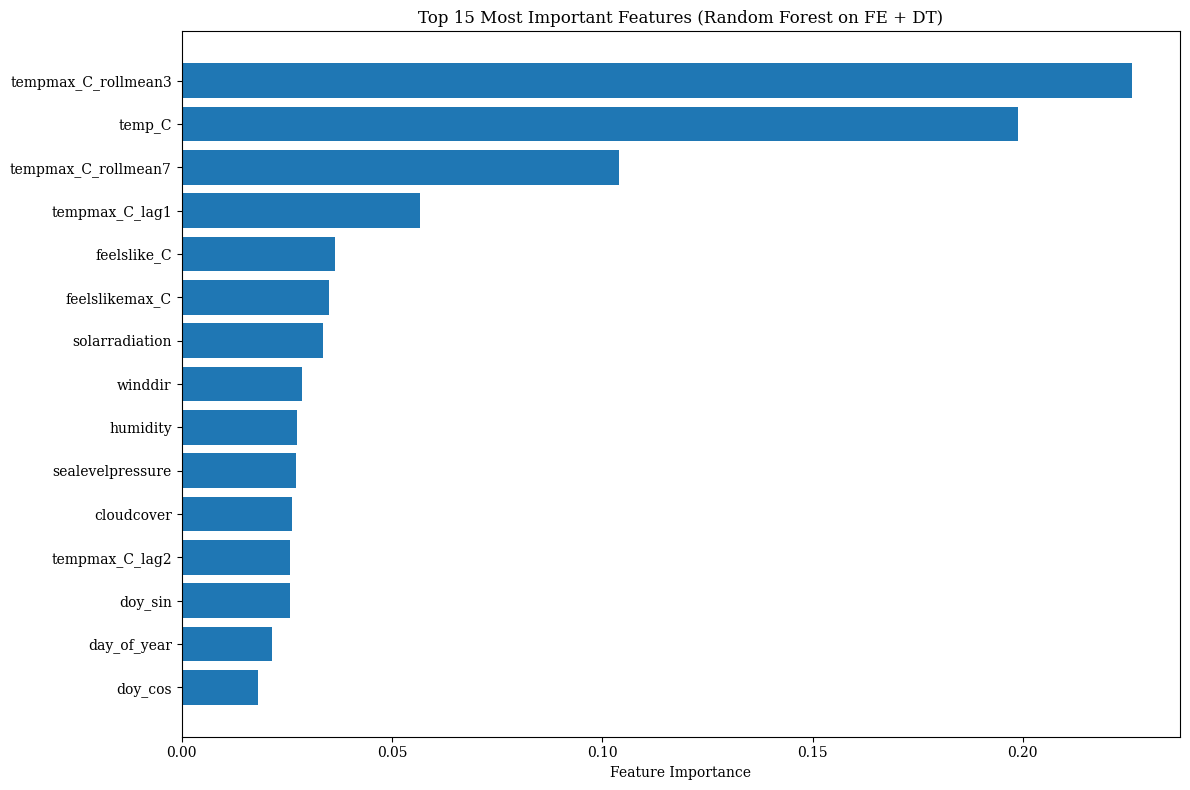

In [ ]:
print("FEATURE IMPORTANCE ANALYSIS")
# Get feature importance from best RandomForest model
feature_importance = rf_fe_dt_model.feature_importances_
feature_names = X_fe_dt_train.columns

# Create importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features (Random Forest on FE + DT)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
